In [1]:
import os, sys
import math
import hydra
import pydicom
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from pydicom.multival import MultiValue
from omegaconf import DictConfig, OmegaConf

warnings.filterwarnings("ignore", category=UserWarning, module="pydicom")

_root = "/".join(os.getcwd().split("/")[:-3])
sys.path.append(os.path.abspath(_root))
from src.datasets.vindr_multiphase.vindr_multiphase import convert_pixel_to_hu, apply_window

INFO:datasets:PyTorch version 2.6.0 available.


# Functions

In [2]:
def create_prompt(result):
    if result['PatientPosition'] == "HFS":
        direction = 'a head-first supine'
    elif result['PatientPosition'] == "FFS":
        direction = 'a feet-first supine'
    else:
        direction = 'an unknown supine'

    if result['SliceThickness'] <= 1.25:
        slice = 'very thin-slice'
    elif result['SliceThickness'] == 2.0:
        slice = 'standard-slice'
    else:
        slice = 'thicker-slice'
    
    if result['Label'].lower() != "non contrast":
        prompt = (
            f"A {result['Label'].lower()} phase contrast-enhanced {slice} CT scan of the abdomen, "
            f"slice number {result['InstanceNumber']}, "
            f"from a {result['PatientAge']}-year-old {result['PatientSex']} patient, "
            f"captured in {direction} position."
        )
    else:
        prompt = (
            f"A {result['Label'].lower()} phase {slice} CT scan of the abdomen, "
            f"slice number {result['InstanceNumber']}, "
            f"from a {result['PatientAge']}-year-old {result['PatientSex']} patient, "
            f"captured in {direction} position."
        )
        
    return prompt

In [3]:
def plot_value_counts(df, column_name, top_n=None, figsize=(10, 5), rotate_xticks=False):
    value_counts = df[column_name].value_counts(dropna=False)

    index_labels = ['NaN' if pd.isna(val) else str(val) for val in value_counts.index]

    if top_n:
        value_counts = value_counts[:top_n]
        index_labels = index_labels[:top_n]

    plot_df = pd.DataFrame({
        column_name: index_labels,
        "Count": value_counts.values
    })

    plt.figure(figsize=figsize)

    ax = sns.barplot(
        data=plot_df,
        x=column_name,
        y="Count",
        hue=column_name,
        palette="husl",
        legend=False
    )

    for i, count in enumerate(plot_df["Count"]):
        ax.text(i, count + 0.01 * max(plot_df["Count"]), str(count),
                ha='center', va='bottom', fontsize=9)

    plt.title(f"Distribution of {column_name}")
    plt.ylabel("Count")
    plt.xlabel(column_name)

    if rotate_xticks:
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

In [4]:
def plot_images(df, num_samples=5, window_center=40, window_width=400, range_instance_number=2201, ascending=True):
    df = df.sort_values(by='InstanceNumber', ascending=ascending)
    df = df[df["InstanceNumber"] <= range_instance_number]
    for idx, row in df.head(num_samples).iterrows():
        dcm_path = os.path.join(_root, row["image_path"].lstrip("./"))
        prompt = row["prompt"]

        dcm = pydicom.dcmread(dcm_path)
        hu_img = convert_pixel_to_hu(dcm)
        windowed_img = apply_window(hu_img, window_center, window_width)

        # Plot
        plt.figure(figsize=(4, 3))
        plt.hist(hu_img.flatten(), bins=100, range=(-1000, 3000), color='gray', alpha=0.7)
        plt.xlabel("HU")
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.show()

        fig, axs = plt.subplots(1, 2, figsize=(8, 5))
        axs[0].imshow(hu_img, cmap='gray')
        axs[0].set_title("Original (HU)")
        axs[0].axis('off')
    
        axs[1].imshow(windowed_img, cmap='gray')
        axs[1].set_title(f"Windowed (Center={window_center}, Width={window_width})")
        axs[1].axis('off')
    
        plt.suptitle(f"Prompt: {prompt}", fontsize=10)
        plt.tight_layout()
        plt.show()
        print("-------------------------" * 5)

In [5]:
def plot_pie_charts(df, columns=['PatientSex', 'PatientAge', 'PatientPosition', 'BodyPartExamined', 'SliceThickness', 'Label']):
    num_cols = len(columns)
    rows = math.ceil(num_cols / 2)  # Arrange in 2 columns
    fig, axes = plt.subplots(rows, 2, figsize=(15, 6 * rows))
    axes = axes.flatten()
    
    for i, col in enumerate(columns):
        counts = df[col].value_counts(dropna=False)  # Include NaN values
        labels = counts.index.astype(str).tolist()
        labels = [label if label != 'nan' else 'NaN' for label in labels]  # Rename NaN for clarity
        
        axes[i].pie(
            counts, 
            labels=labels, 
            autopct='%1.1f%%', 
            startangle=90, 
            colors=plt.cm.Paired.colors
        )
        axes[i].set_title(f'{col} Distribution')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

# Explore data MERGED DATA

In [6]:
print(f"Project: {os.listdir(_root)}")
dataset_dir = _root + "/data/vindr_multiphase"
print(f"VinDrMultiphase: {os.listdir(dataset_dir)}")

Project: ['.gitignore', 'results', 'src', 'LICENSE', 'README.md', '.git', 'configs', 'data']
VinDrMultiphase: ['biobert_embeddings', 'metadata.csv', 'clip_embeddings', 'metadata_prompt.csv', 't5_embeddings', 'abdomen_phases']


In [7]:
label_df = pd.read_csv(dataset_dir + "/abdomen_phases/labels.csv")
label_df.head(5)

StudyInstanceUID  \
0  1.2.392.200036.9116.2.5.1.37.2418751871.143269...   
1  1.2.392.200036.9116.2.5.1.37.2418751871.143269...   
2  1.2.392.200036.9116.2.5.1.37.2418751871.143269...   
3  1.2.392.200036.9116.2.5.1.37.2418751871.149792...   
4  1.2.392.200036.9116.2.5.1.37.2418751871.149792...   

                                   SeriesInstanceUID         Label  
0  1.2.392.200036.9116.2.5.1.37.2418751871.143269...  Non-contrast  
1  1.2.392.200036.9116.2.5.1.37.2418751871.143269...       Aterial  
2  1.2.392.200036.9116.2.5.1.37.2418751871.143269...        Venous  
3  1.2.392.200036.9116.2.5.1.37.2418751871.149792...  Non-contrast  
4  1.2.392.200036.9116.2.5.1.37.2418751871.149792...       Aterial

In [8]:
metadata = dataset_dir + "/metadata.csv"
df = pd.read_csv(metadata, low_memory=False)
df.head(5)

image_path  z_position  \
0  ./data/vindr_multiphase/abdomen_phases/batch6/...      -132.5   
1  ./data/vindr_multiphase/abdomen_phases/batch6/...      -102.5   
2  ./data/vindr_multiphase/abdomen_phases/batch6/...       -87.5   
3  ./data/vindr_multiphase/abdomen_phases/batch6/...       -32.5   
4  ./data/vindr_multiphase/abdomen_phases/batch6/...       -42.5   

                                    StudyInstanceUID  \
0  1.2.840.113619.2.359.3.2831208971.49.155787871...   
1  1.2.840.113619.2.359.3.2831208971.49.155787871...   
2  1.2.840.113619.2.359.3.2831208971.49.155787871...   
3  1.2.840.113619.2.359.3.2831208971.49.155787871...   
4  1.2.840.113619.2.359.3.2831208971.49.155787871...   

                                   SeriesInstanceUID  \
0  1.2.840.113619.2.359.3.2831208971.49.155787871...   
1  1.2.840.113619.2.359.3.2831208971.49.155787871...   
2  1.2.840.113619.2.359.3.2831208971.49.155787871...   
3  1.2.840.113619.2.359.3.2831208971.49.155787871...   
4  1.2.840.113619.2.359.3.2831208971.49.155787871...   

                                      SOPInstanceUID PatientSex PatientAge  \
0  1.2.840.113619.2.359.3.2831208971.49.155787871...          M       000Y   
1  1.2.840.113619.2.359.3.2831208971.49.155787871...          M       000Y   
2  1.2.840.113619.2.359.3.2831208971.49.155787871...          M       000Y   
3  1.2.840.113619.2.359.3.2831208971.49.155787871...          M       000Y   
4  1.2.840.113619.2.359.3.2831208971.49.155787871...          M       000Y   

   PatientWeight PatientPosition Modality BodyPartExamined   ScanOptions  \
0            NaN             FFS       CT              NaN  HELICAL MODE   
1            NaN             FFS       CT              NaN  HELICAL MODE   
2            NaN             FFS       CT              NaN  HELICAL MODE   
3            NaN             FFS       CT              NaN  HELICAL MODE   
4            NaN             FFS       CT              NaN  HELICAL MODE   

  ContrastBolusAgent  ContrastBolusStartTime  InstanceNumber  SliceLocation  \
0                NaN                     NaN              23         -132.5   
1                NaN                     NaN              17         -102.5   
2                NaN                     NaN              14          -87.5   
3                NaN                     NaN               3          -32.5   
4                NaN                     NaN               5          -42.5   

           PixelSpacing  SliceThickness  \
0  [0.619141, 0.619141]             5.0   
1  [0.619141, 0.619141]             5.0   
2  [0.619141, 0.619141]             5.0   
3  [0.619141, 0.619141]             5.0   
4  [0.619141, 0.619141]             5.0   

                             ImageOrientationPatient  
0  [1.000000, 0.000000, 0.000000, 0.000000, 1.000...  
1  [1.000000, 0.000000, 0.000000, 0.000000, 1.000...  
2  [1.000000, 0.000000, 0.000000, 0.000000, 1.000...  
3  [1.000000, 0.000000, 0.000000, 0.000000, 1.000...  
4  [1.000000, 0.000000, 0.000000, 0.000000, 1.000...

In [9]:
merged_df = pd.merge(df, label_df, on=['StudyInstanceUID', 'SeriesInstanceUID'], how='outer')
merged_df["PatientAge"] = merged_df["PatientAge"].replace({'58': '058Y', '52': '052Y', '000Y': 'unknown'})
print(merged_df.shape)
merged_df.describe()

(392560, 20)


z_position  PatientWeight  ContrastBolusStartTime  InstanceNumber  \
count  392560.000000  148433.000000           102852.000000   392560.000000   
mean      339.605457      60.132046           104901.241420      387.207584   
std       852.420566       5.126369            22413.314195      418.756425   
min      -706.750000      50.000000            72947.400000        1.000000   
25%      -262.500000      55.000000            92513.000000       90.000000   
50%      -102.500000      60.000000           102538.050000      222.000000   
75%      1438.300000      65.000000           111021.150000      525.000000   
max      2219.500000      73.000000           184801.800000     2201.000000   

       SliceLocation  SliceThickness  
count  392560.000000   392560.000000  
mean      -33.972538        1.194379  
std       256.759770        1.016203  
min      -706.750000        0.500000  
25%      -227.500000        0.500000  
50%       -61.250000        1.250000  
75%       164.700000        1.250000  
max       650.000000        5.000000

In [10]:
merged_df['Label'] = merged_df['Label'].str.replace('Non-contrast', 'Non contrast').str.replace('Aterial', 'Arterial')
merged_df['PatientSex'] = merged_df['PatientSex'].map({'M': 'male', 'F': 'female'})
merged_df['PatientAge'] = merged_df['PatientAge'].str.replace('Y', '').str.lstrip('0')
categorical_columns = [
    'PatientSex', 'PatientAge', 'PatientPosition', 'Modality', 'BodyPartExamined', 'ScanOptions', 'ContrastBolusAgent', 'Label'
]

for col in categorical_columns:
    merged_df[col] = merged_df[col].astype('category')

merged_df['PatientWeight'] = merged_df['PatientWeight'].astype(float)

print(merged_df.dtypes)

image_path                   object
z_position                  float64
StudyInstanceUID             object
SeriesInstanceUID            object
SOPInstanceUID               object
PatientSex                 category
PatientAge                 category
PatientWeight               float64
PatientPosition            category
Modality                   category
BodyPartExamined           category
ScanOptions                category
ContrastBolusAgent         category
ContrastBolusStartTime      float64
InstanceNumber                int64
SliceLocation               float64
PixelSpacing                 object
SliceThickness              float64
ImageOrientationPatient      object
Label                      category
dtype: object


# Statistics of MERGED DATA

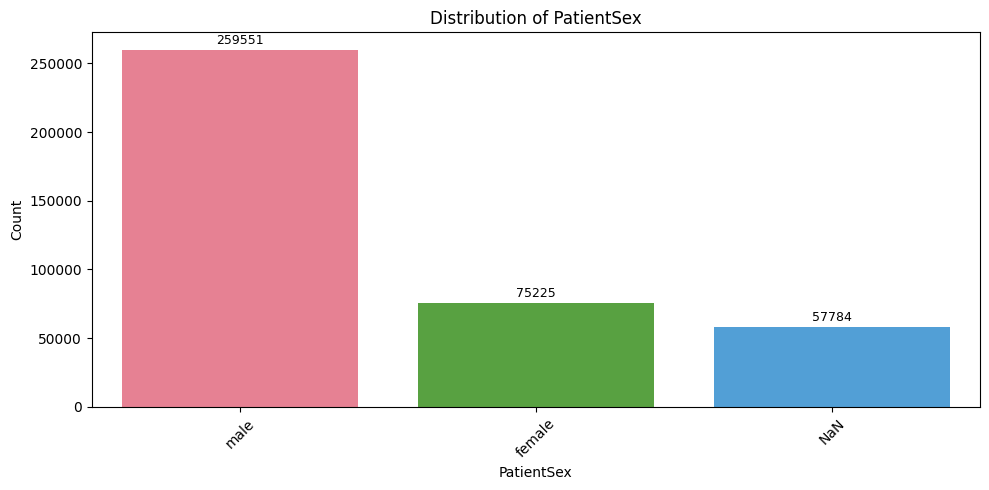

In [11]:
plot_value_counts(merged_df, "PatientSex", rotate_xticks=True)

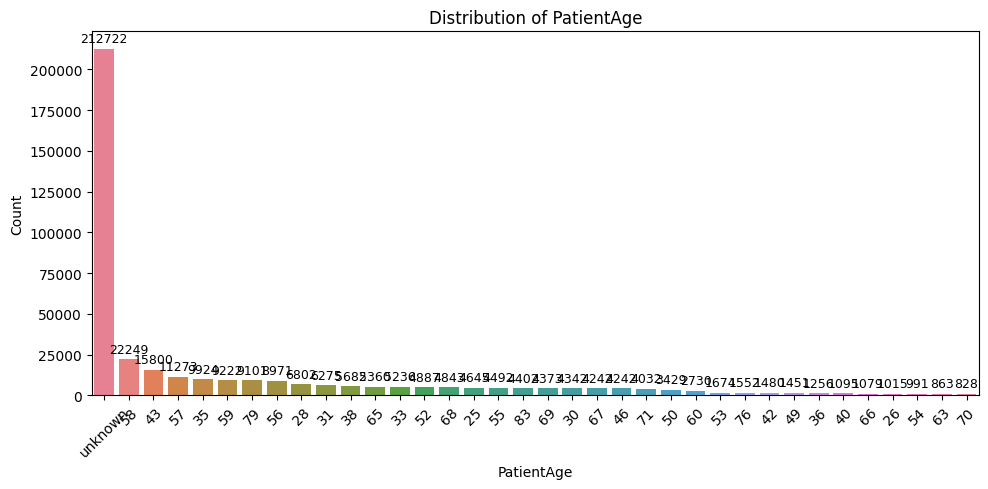

In [12]:
plot_value_counts(merged_df, "PatientAge", rotate_xticks=True)

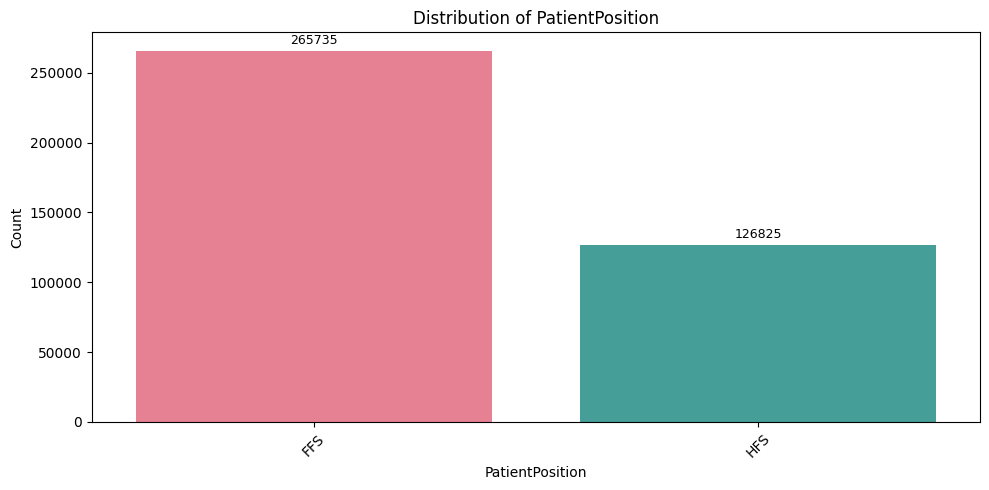

In [13]:
plot_value_counts(merged_df, "PatientPosition", rotate_xticks=True)

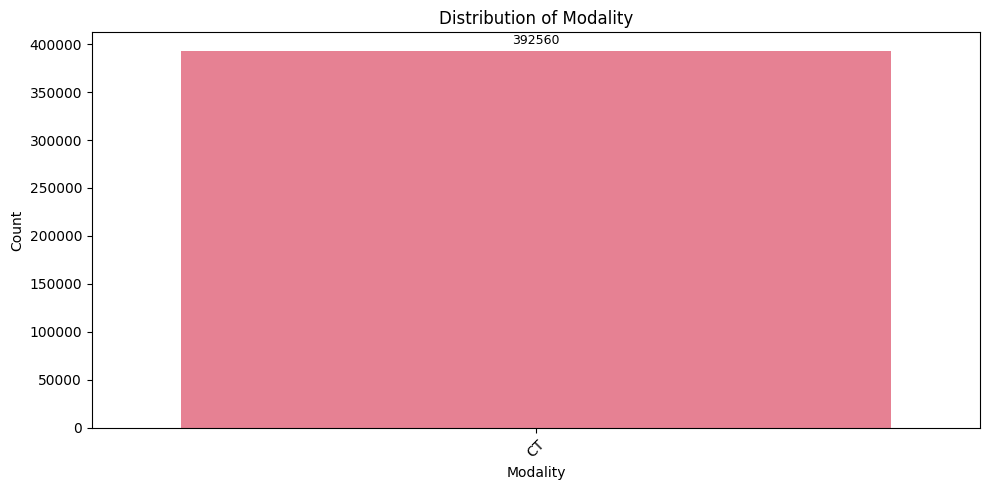

In [14]:
plot_value_counts(merged_df, "Modality", rotate_xticks=True)

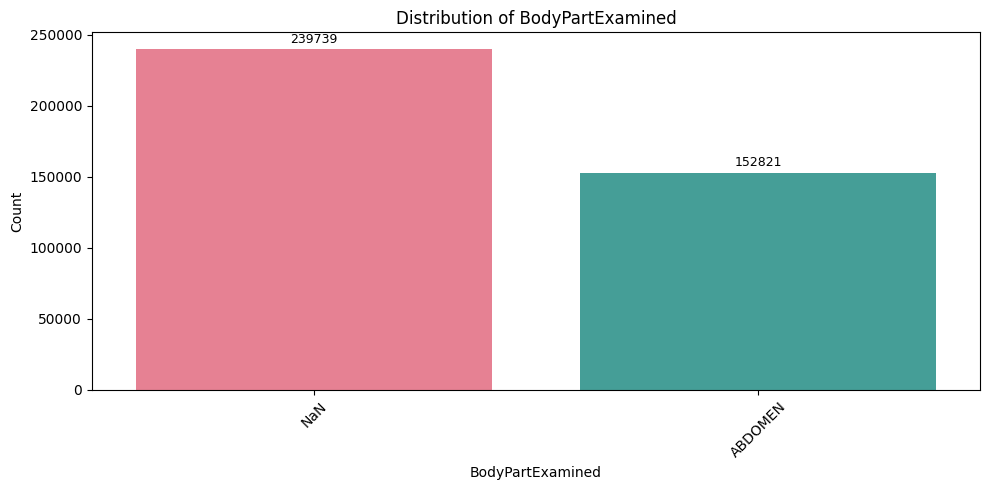

In [15]:
plot_value_counts(merged_df, "BodyPartExamined", rotate_xticks=True)

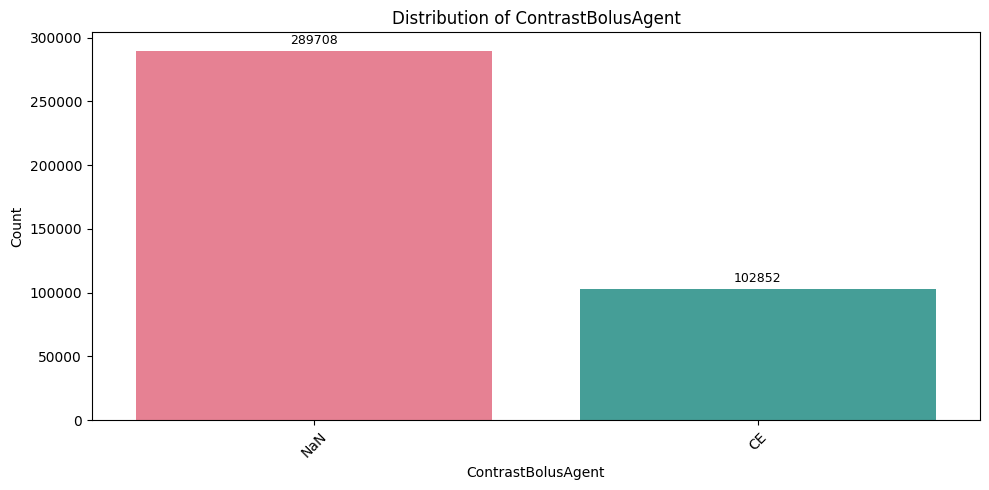

In [16]:
plot_value_counts(merged_df, "ContrastBolusAgent", rotate_xticks=True)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


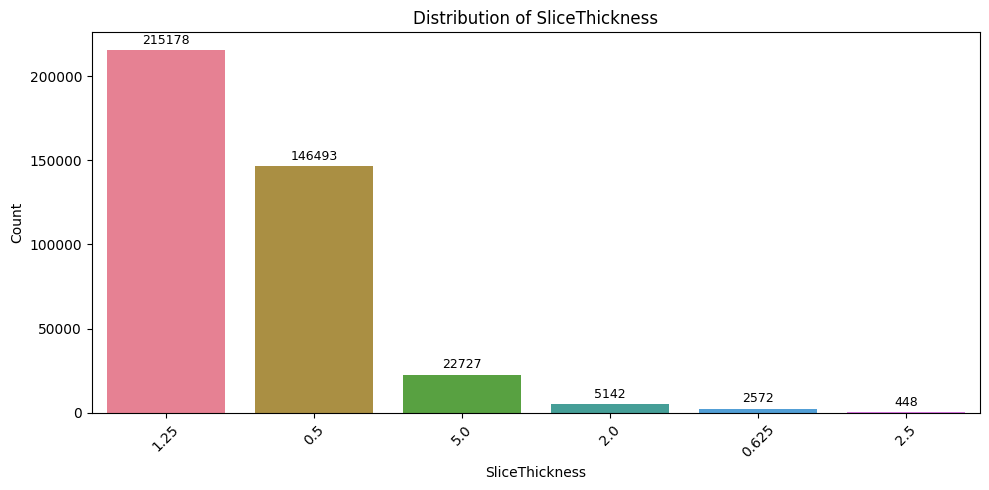

In [17]:
plot_value_counts(merged_df, "SliceThickness", rotate_xticks=True)

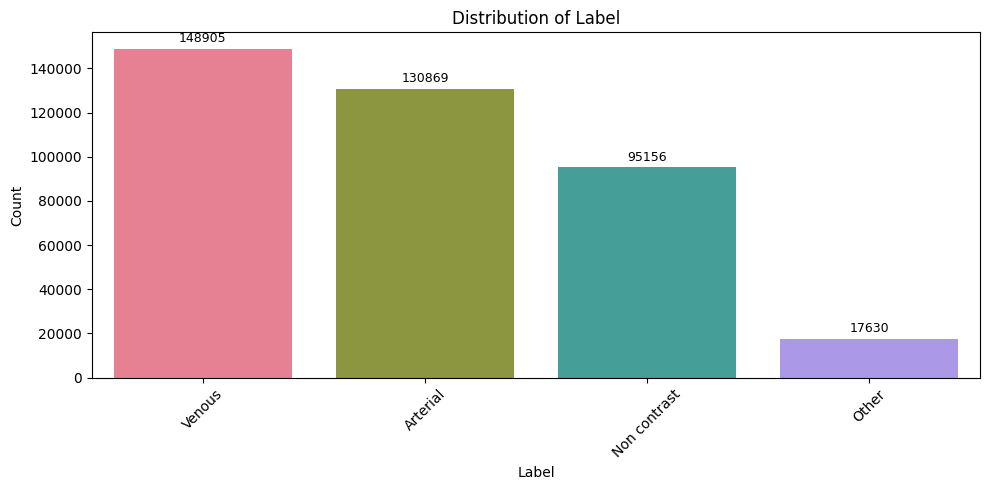

In [18]:
plot_value_counts(merged_df, "Label", rotate_xticks=True)

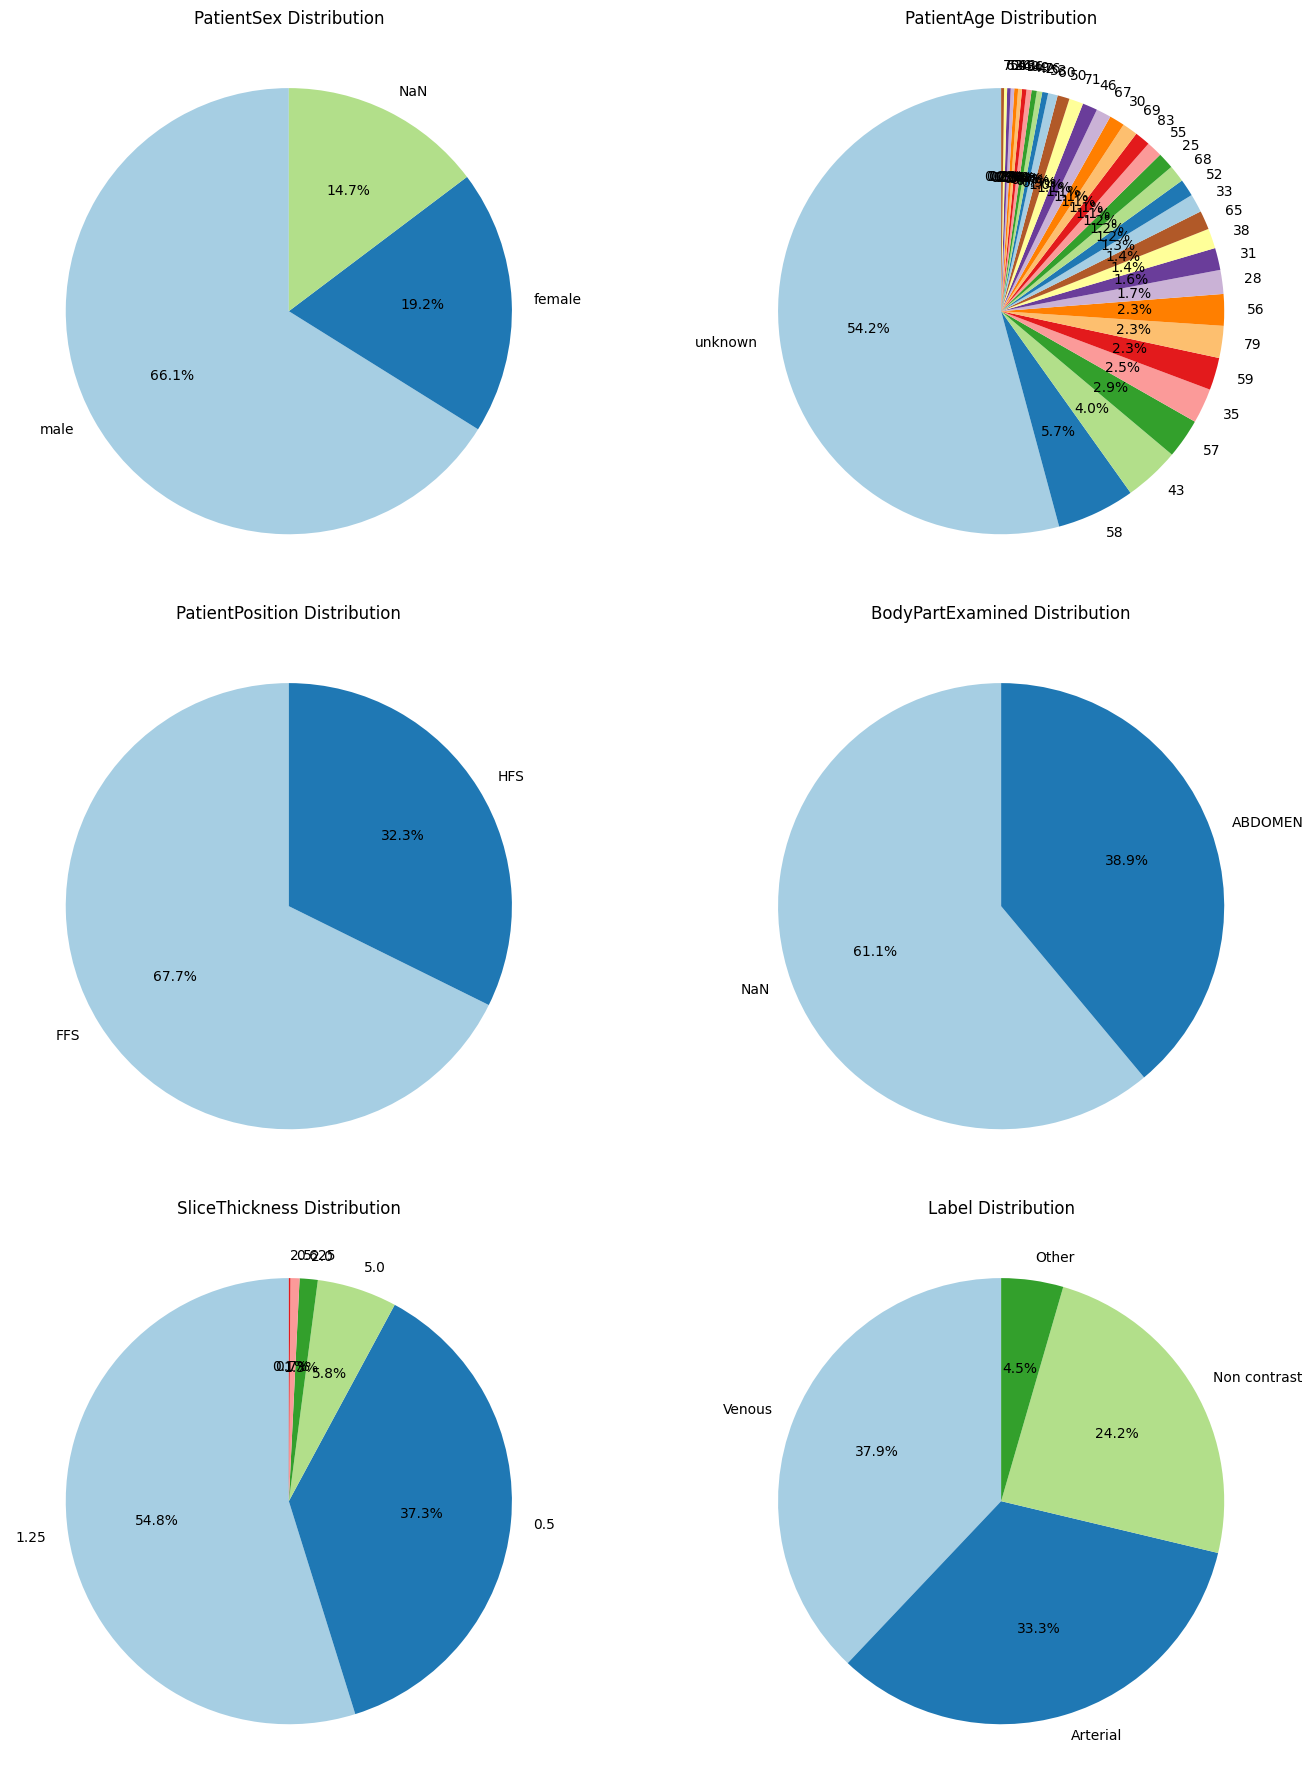

In [19]:
plot_pie_charts(merged_df)

# CLEANED DATA

In [20]:
cleaned_df = merged_df.copy()
cleaned_df = cleaned_df.dropna(subset=['PatientSex'])
cleaned_df = cleaned_df[cleaned_df["PatientAge"] != "unknown"]
cleaned_df = cleaned_df[cleaned_df["Label"] != "Other"]
cleaned_df = cleaned_df[cleaned_df["Label"] != "Other"]
cleaned_df = cleaned_df.reset_index(drop=True)
print(cleaned_df.shape)
cleaned_df.head()

(175835, 20)


image_path  z_position  \
0  ./data/vindr_multiphase/abdomen_phases/batch1/...      1674.2   
1  ./data/vindr_multiphase/abdomen_phases/batch1/...      1521.5   
2  ./data/vindr_multiphase/abdomen_phases/batch1/...      1801.1   
3  ./data/vindr_multiphase/abdomen_phases/batch1/...      1575.5   
4  ./data/vindr_multiphase/abdomen_phases/batch1/...      1694.6   

                                    StudyInstanceUID  \
0  1.2.392.200036.9116.2.5.1.37.2418751871.143269...   
1  1.2.392.200036.9116.2.5.1.37.2418751871.143269...   
2  1.2.392.200036.9116.2.5.1.37.2418751871.143269...   
3  1.2.392.200036.9116.2.5.1.37.2418751871.143269...   
4  1.2.392.200036.9116.2.5.1.37.2418751871.143269...   

                                   SeriesInstanceUID  \
0  1.2.392.200036.9116.2.5.1.37.2418751871.143269...   
1  1.2.392.200036.9116.2.5.1.37.2418751871.143269...   
2  1.2.392.200036.9116.2.5.1.37.2418751871.143269...   
3  1.2.392.200036.9116.2.5.1.37.2418751871.143269...   
4  1.2.392.200036.9116.2.5.1.37.2418751871.143269...   

                                      SOPInstanceUID PatientSex PatientAge  \
0  1.2.392.200036.9116.2.5.1.37.2418751871.143269...       male         56   
1  1.2.392.200036.9116.2.5.1.37.2418751871.143269...       male         56   
2  1.2.392.200036.9116.2.5.1.37.2418751871.143269...       male         56   
3  1.2.392.200036.9116.2.5.1.37.2418751871.143269...       male         56   
4  1.2.392.200036.9116.2.5.1.37.2418751871.143269...       male         56   

   PatientWeight PatientPosition Modality BodyPartExamined ScanOptions  \
0           55.0             FFS       CT          ABDOMEN  HELICAL_CT   
1           55.0             FFS       CT          ABDOMEN  HELICAL_CT   
2           55.0             FFS       CT          ABDOMEN  HELICAL_CT   
3           55.0             FFS       CT          ABDOMEN  HELICAL_CT   
4           55.0             FFS       CT          ABDOMEN  HELICAL_CT   

  ContrastBolusAgent  ContrastBolusStartTime  InstanceNumber  SliceLocation  \
0                NaN                     NaN             517          154.8   
1                NaN                     NaN            1026          307.5   
2                NaN                     NaN              94           27.9   
3                NaN                     NaN             846          253.5   
4                NaN                     NaN             449          134.4   

     PixelSpacing  SliceThickness  \
0  [0.782, 0.782]             0.5   
1  [0.782, 0.782]             0.5   
2  [0.782, 0.782]             0.5   
3  [0.782, 0.782]             0.5   
4  [0.782, 0.782]             0.5   

                             ImageOrientationPatient         Label  
0  [1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...  Non contrast  
1  [1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...  Non contrast  
2  [1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...  Non contrast  
3  [1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...  Non contrast  
4  [1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...  Non contrast

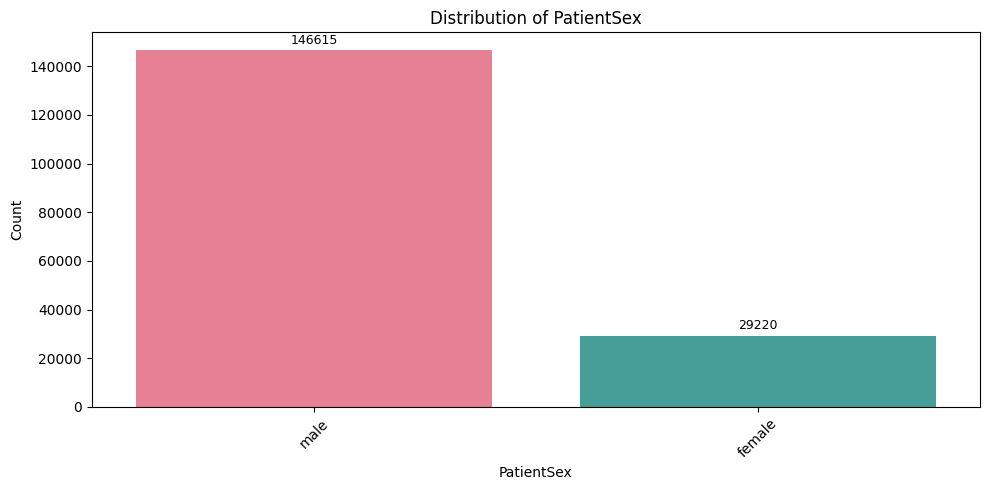

In [21]:
plot_value_counts(cleaned_df, "PatientSex", rotate_xticks=True)

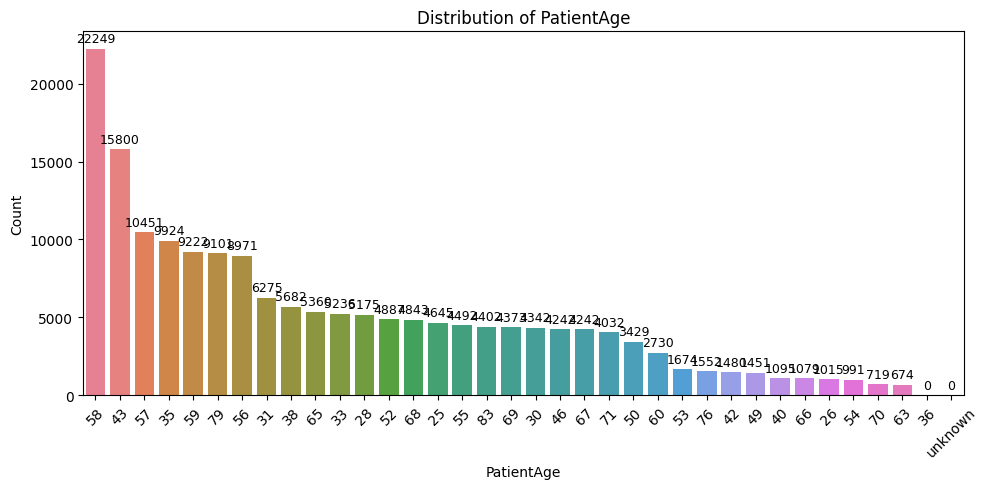

In [22]:
plot_value_counts(cleaned_df, "PatientAge", rotate_xticks=True)

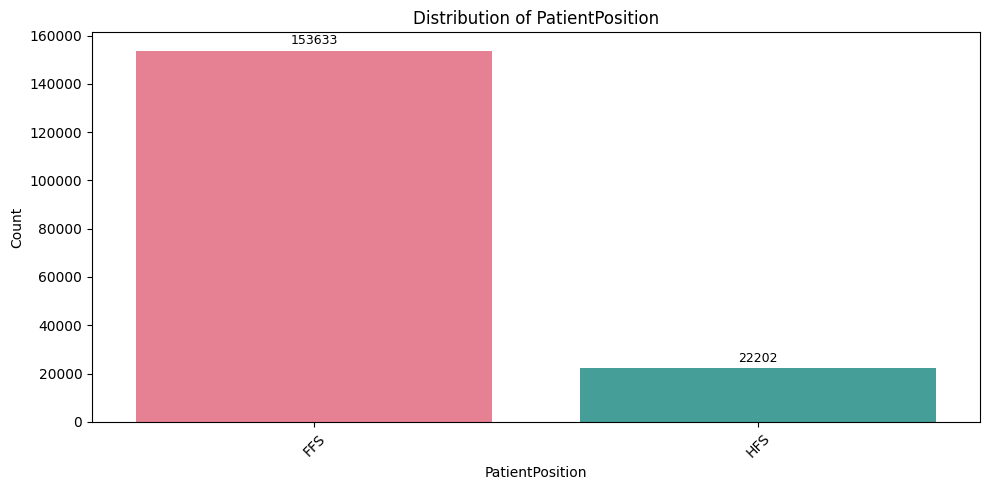

In [23]:
plot_value_counts(cleaned_df, "PatientPosition", rotate_xticks=True)

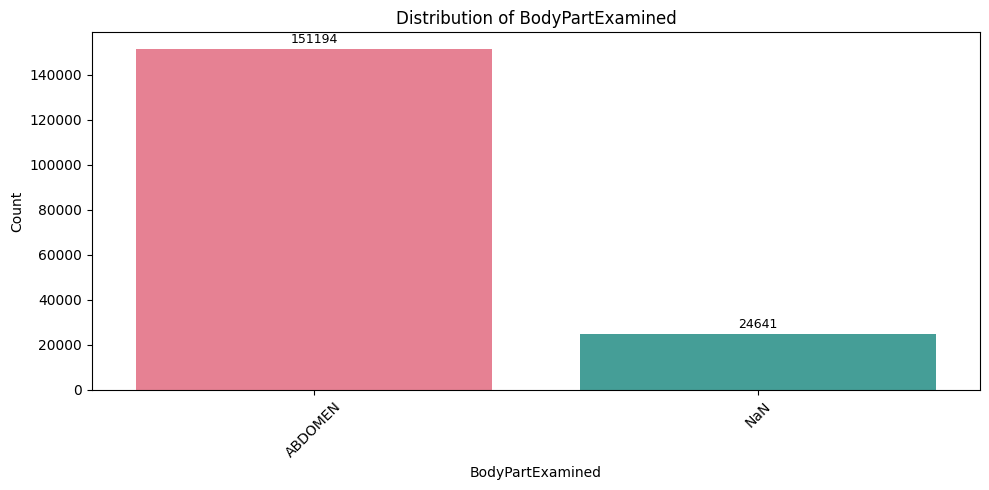

In [24]:
plot_value_counts(cleaned_df, "BodyPartExamined", rotate_xticks=True)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


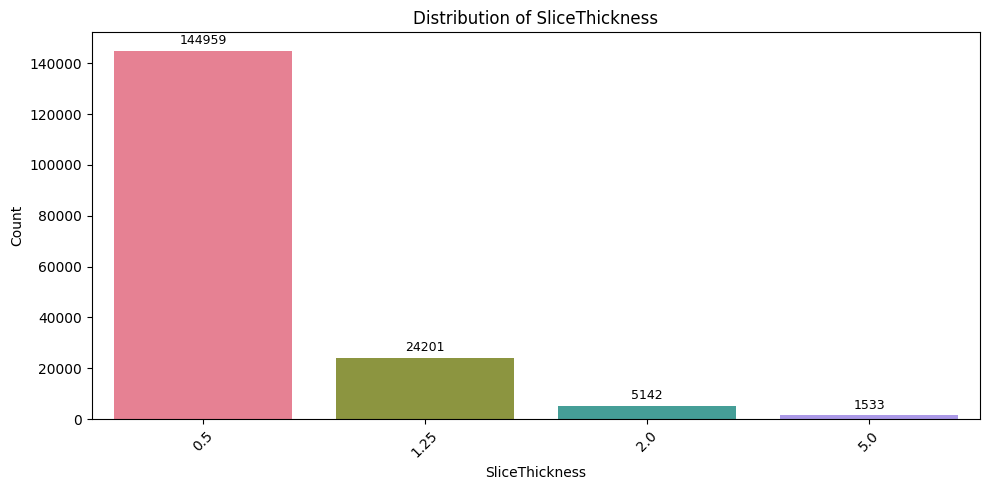

In [25]:
plot_value_counts(cleaned_df, "SliceThickness", rotate_xticks=True)

In [26]:
plot_value_counts(cleaned_df, "Label", rotate_xticks=True)

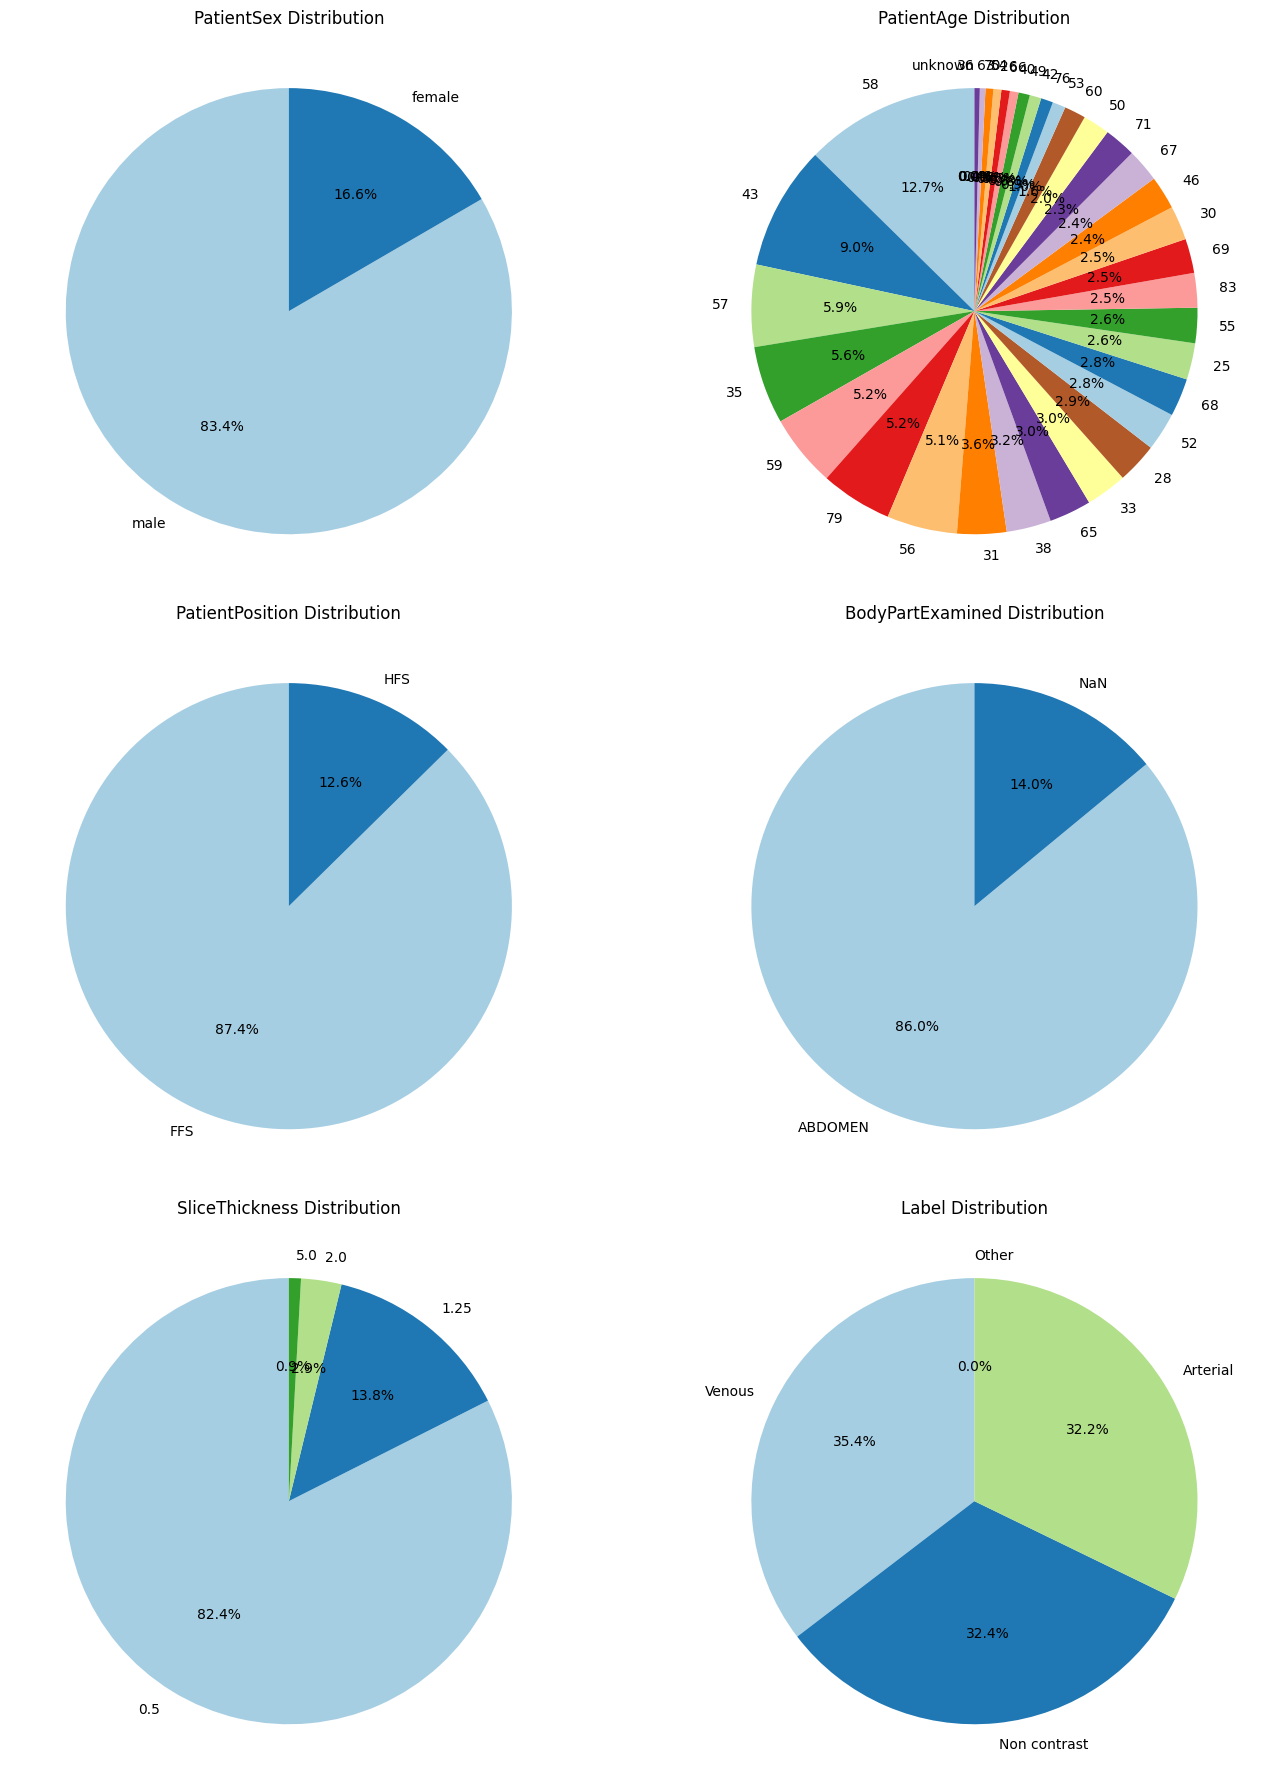

In [27]:
plot_pie_charts(cleaned_df)

# Create Prompts & Final METADATA PROMPT 

In [28]:
cleaned_df['prompt'] = cleaned_df.apply(create_prompt, axis=1)
print(cleaned_df.shape)

(175835, 21)


In [33]:
# Choose range InstanceNumber from 1 to 1000 concentrate on ABDOMEN
final_df = cleaned_df[cleaned_df["InstanceNumber"] <= 1000]

# Remove series taken from head 
final_df = final_df[
    (final_df['SeriesInstanceUID'] != "1.2.840.113619.2.278.3.717616.166.1580339212.915.4") &
    (final_df['SeriesInstanceUID'] != "1.2.840.113619.2.278.3.717616.166.1580339213.59.5251074")
]

#
final_df = final_df.reset_index(drop=True)
print(final_df.shape)
print(f"Number of patient: {len(final_df['StudyInstanceUID'].unique())}")
print(f"Unique prompt: {len(final_df['prompt'].unique().tolist())}")
final_df.head()

(125738, 21)
Number of patient: 54
Unique prompt: 97503


image_path  z_position  \
0  ./data/vindr_multiphase/abdomen_phases/batch1/...      1674.2   
1  ./data/vindr_multiphase/abdomen_phases/batch1/...      1801.1   
2  ./data/vindr_multiphase/abdomen_phases/batch1/...      1575.5   
3  ./data/vindr_multiphase/abdomen_phases/batch1/...      1694.6   
4  ./data/vindr_multiphase/abdomen_phases/batch1/...      1775.0   

                                    StudyInstanceUID  \
0  1.2.392.200036.9116.2.5.1.37.2418751871.143269...   
1  1.2.392.200036.9116.2.5.1.37.2418751871.143269...   
2  1.2.392.200036.9116.2.5.1.37.2418751871.143269...   
3  1.2.392.200036.9116.2.5.1.37.2418751871.143269...   
4  1.2.392.200036.9116.2.5.1.37.2418751871.143269...   

                                   SeriesInstanceUID  \
0  1.2.392.200036.9116.2.5.1.37.2418751871.143269...   
1  1.2.392.200036.9116.2.5.1.37.2418751871.143269...   
2  1.2.392.200036.9116.2.5.1.37.2418751871.143269...   
3  1.2.392.200036.9116.2.5.1.37.2418751871.143269...   
4  1.2.392.200036.9116.2.5.1.37.2418751871.143269...   

                                      SOPInstanceUID PatientSex PatientAge  \
0  1.2.392.200036.9116.2.5.1.37.2418751871.143269...       male         56   
1  1.2.392.200036.9116.2.5.1.37.2418751871.143269...       male         56   
2  1.2.392.200036.9116.2.5.1.37.2418751871.143269...       male         56   
3  1.2.392.200036.9116.2.5.1.37.2418751871.143269...       male         56   
4  1.2.392.200036.9116.2.5.1.37.2418751871.143269...       male         56   

   PatientWeight PatientPosition Modality  ... ScanOptions ContrastBolusAgent  \
0           55.0             FFS       CT  ...  HELICAL_CT                NaN   
1           55.0             FFS       CT  ...  HELICAL_CT                NaN   
2           55.0             FFS       CT  ...  HELICAL_CT                NaN   
3           55.0             FFS       CT  ...  HELICAL_CT                NaN   
4           55.0             FFS       CT  ...  HELICAL_CT                NaN   

  ContrastBolusStartTime  InstanceNumber  SliceLocation    PixelSpacing  \
0                    NaN             517          154.8  [0.782, 0.782]   
1                    NaN              94           27.9  [0.782, 0.782]   
2                    NaN             846          253.5  [0.782, 0.782]   
3                    NaN             449          134.4  [0.782, 0.782]   
4                    NaN             181           54.0  [0.782, 0.782]   

  SliceThickness                            ImageOrientationPatient  \
0            0.5  [1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...   
1            0.5  [1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...   
2            0.5  [1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...   
3            0.5  [1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...   
4            0.5  [1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...   

          Label                                             prompt  
0  Non contrast  A non contrast phase very thin-slice CT scan o...  
1  Non contrast  A non contrast phase very thin-slice CT scan o...  
2  Non contrast  A non contrast phase very thin-slice CT scan o...  
3  Non contrast  A non contrast phase very thin-slice CT scan o...  
4  Non contrast  A non contrast phase very thin-slice CT scan o...  

[5 rows x 21 columns]

In [34]:
final_df.describe()

z_position  PatientWeight  ContrastBolusStartTime  InstanceNumber  \
count  125738.000000  106886.000000            69172.000000   125738.000000   
mean      981.713447      59.908501           105630.119606      421.854857   
std       926.738281       4.987054            22756.275490      293.990327   
min      -681.250000      50.000000            72947.400000        1.000000   
25%      -137.000000      55.000000            92513.000000      166.000000   
50%      1552.700000      60.000000           102538.050000      359.000000   
75%      1706.000000      65.000000           111021.150000      673.000000   
max      2219.500000      73.000000           184801.800000     1000.000000   

       SliceLocation  SliceThickness  
count  125738.000000   125738.000000  
mean       81.721179        0.753772  
std       192.005438        0.614555  
min      -681.250000        0.500000  
25%        24.200000        0.500000  
50%       119.500000        0.500000  
75%       214.800000        0.500000  
max       650.000000        5.000000

# Visualize

In [35]:
print(final_df['StudyInstanceUID'][0])
batch_168588 = final_df[final_df['StudyInstanceUID'] == final_df['StudyInstanceUID'][0]]
print(batch_168588['Label'].value_counts())
print(batch_168588['prompt'][0])

1.2.392.200036.9116.2.5.1.37.2418751871.1432695579.168588
Label
Arterial        1000
Non contrast    1000
Venous          1000
Other              0
Name: count, dtype: int64
A non contrast phase very thin-slice CT scan of the abdomen, slice number 517, from a 56-year-old male patient, captured in a feet-first supine position.


## Non-contrast phase

In [36]:
non_constrast_df = batch_168588[batch_168588['Label'] == "Non contrast"]
print(non_constrast_df.shape)
print(f"z_position_range {non_constrast_df['z_position'].max() - non_constrast_df['z_position'].min()}:\n min {non_constrast_df['z_position'].min()} | max {non_constrast_df['z_position'].max()}")
print(f"SliceLocation_range {non_constrast_df['SliceLocation'].max() - non_constrast_df['SliceLocation'].min()}:\n min {non_constrast_df['SliceLocation'].min()} | max {non_constrast_df['SliceLocation'].max()}")
print(f"InstanceNumber: min {non_constrast_df['InstanceNumber'].min()} | max {non_constrast_df['InstanceNumber'].max()}")
print(non_constrast_df['Label'].value_counts())

(1000, 21)
z_position_range 299.70000000000005:
 min 1529.3 | max 1829.0
SliceLocation_range 299.7:
 min 0.0 | max 299.7
InstanceNumber: min 1 | max 1000
Label
Non contrast    1000
Arterial           0
Other              0
Venous             0
Name: count, dtype: int64


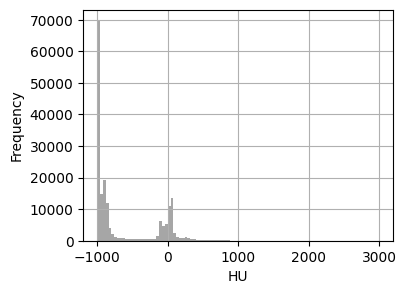

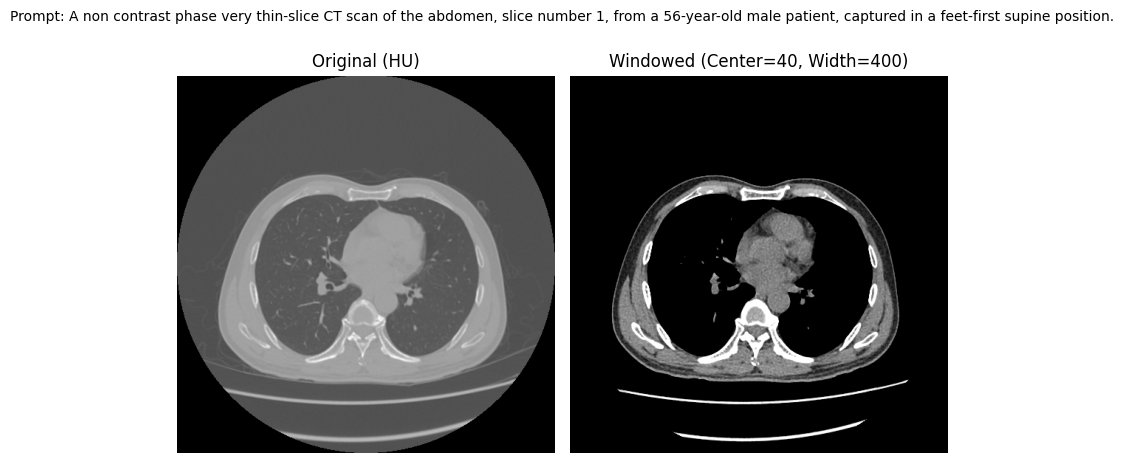

-----------------------------------------------------------------------------------------------------------------------------


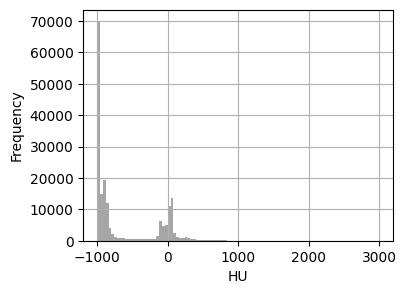

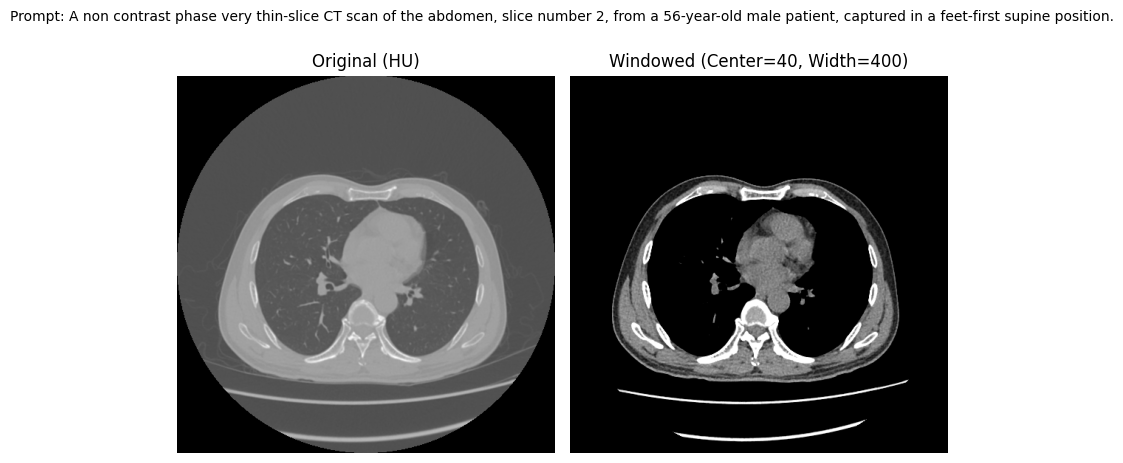

-----------------------------------------------------------------------------------------------------------------------------


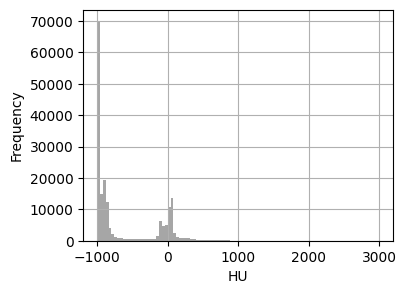

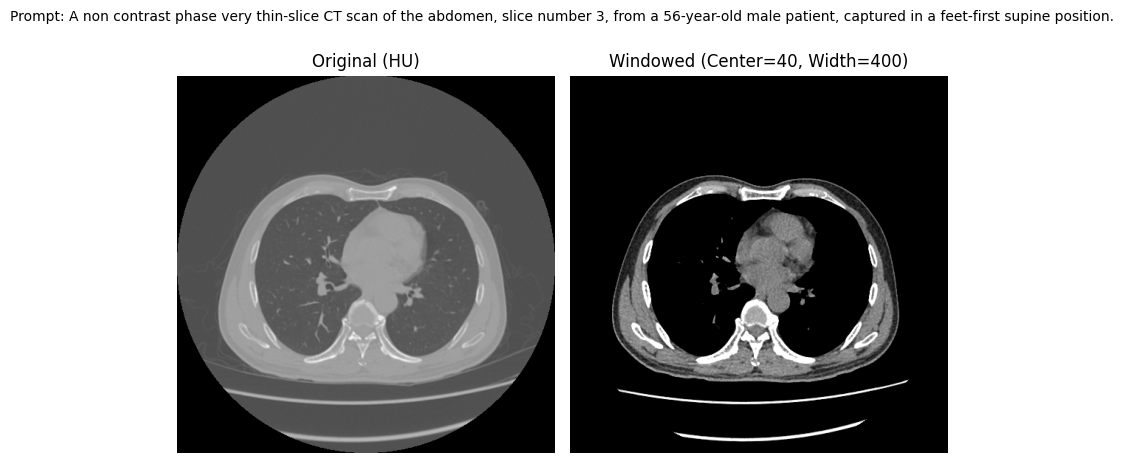

-----------------------------------------------------------------------------------------------------------------------------


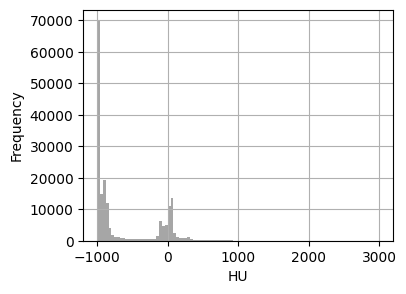

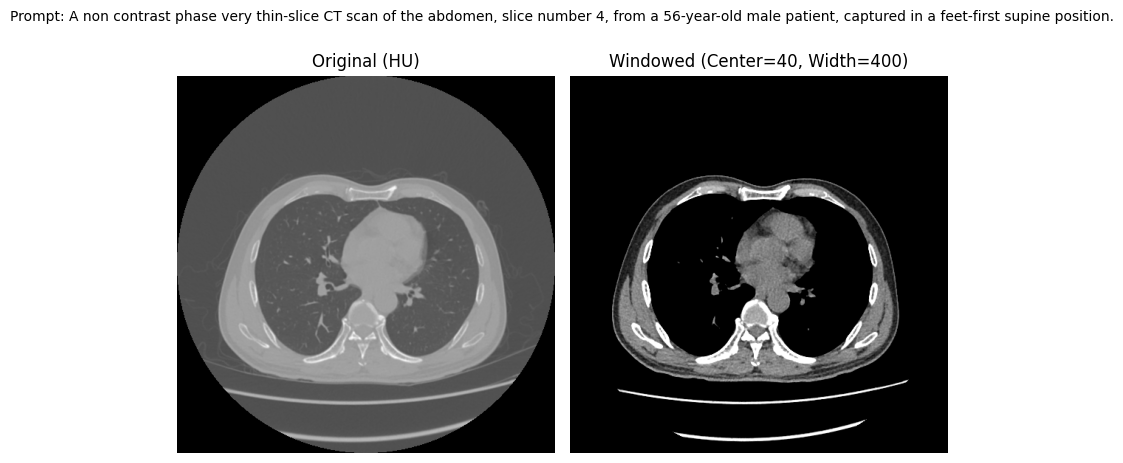

-----------------------------------------------------------------------------------------------------------------------------


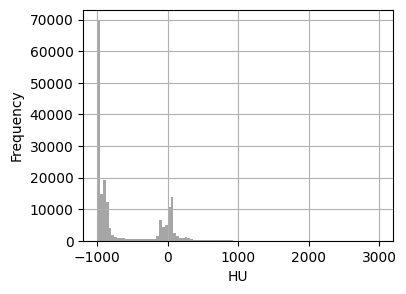

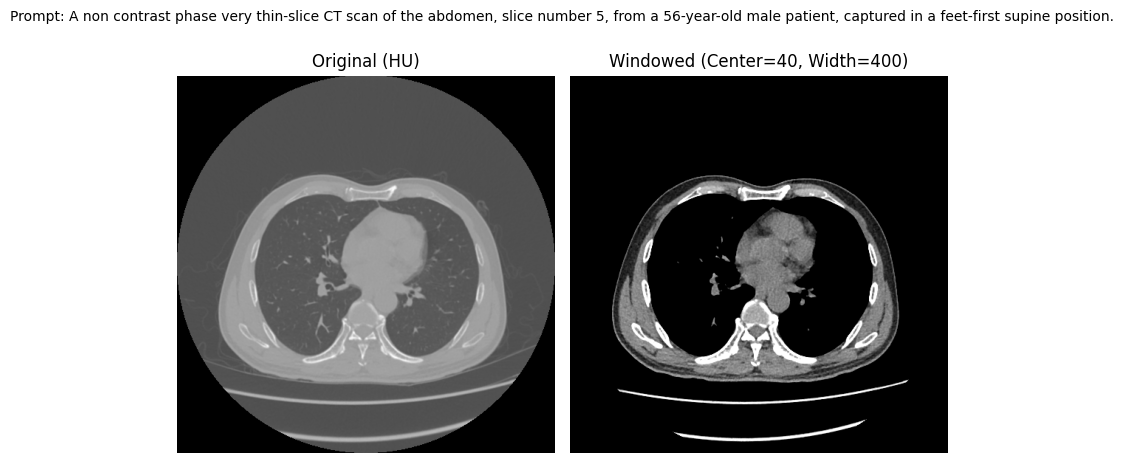

-----------------------------------------------------------------------------------------------------------------------------


In [37]:
plot_images(non_constrast_df, num_samples=5, window_center=40, window_width=400, range_instance_number=2201, ascending=True)

## Arterial phase

In [38]:
arterial_df = batch_168588[batch_168588['Label'] == "Arterial"]
print(arterial_df.shape)
print(f"z_position_range {arterial_df['z_position'].max() - arterial_df['z_position'].min()}:\n min {arterial_df['z_position'].min()} | max {arterial_df['z_position'].max()}")
print(f"SliceLocation_range {arterial_df['SliceLocation'].max() - arterial_df['SliceLocation'].min()}:\n min {arterial_df['SliceLocation'].min()} | max {arterial_df['SliceLocation'].max()}")
print(f"InstanceNumber: min {arterial_df['InstanceNumber'].min()} | max {arterial_df['InstanceNumber'].max()}")
print(arterial_df['Label'].value_counts())

(1000, 21)
z_position_range 299.70000000000005:
 min 1543.8 | max 1843.5
SliceLocation_range 299.7:
 min -14.5 | max 285.2
InstanceNumber: min 1 | max 1000
Label
Arterial        1000
Non contrast       0
Other              0
Venous             0
Name: count, dtype: int64


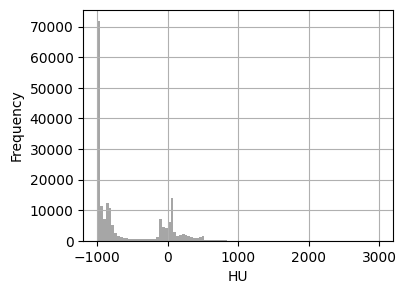

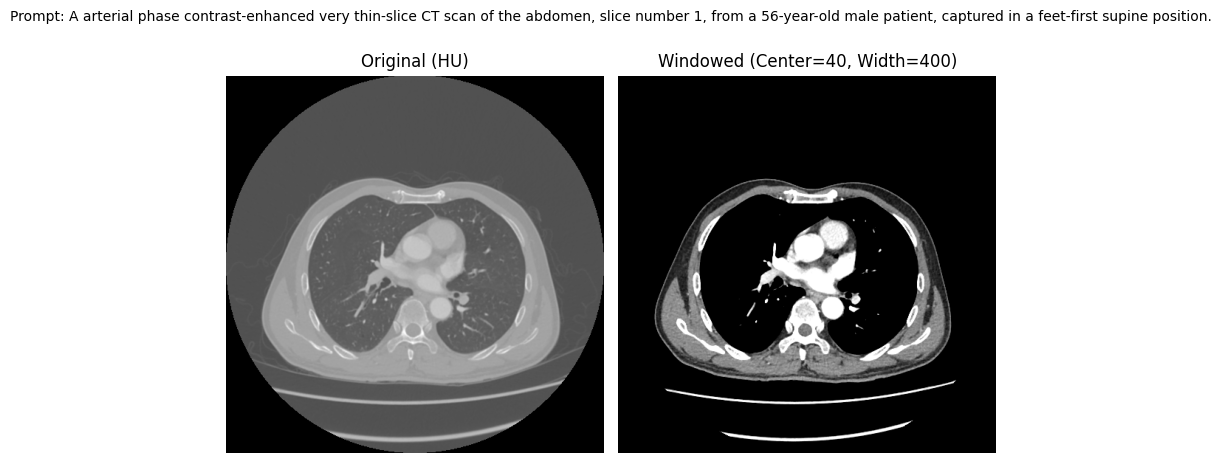

-----------------------------------------------------------------------------------------------------------------------------


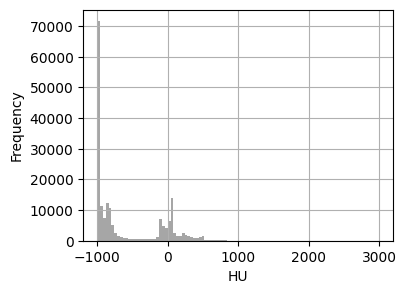

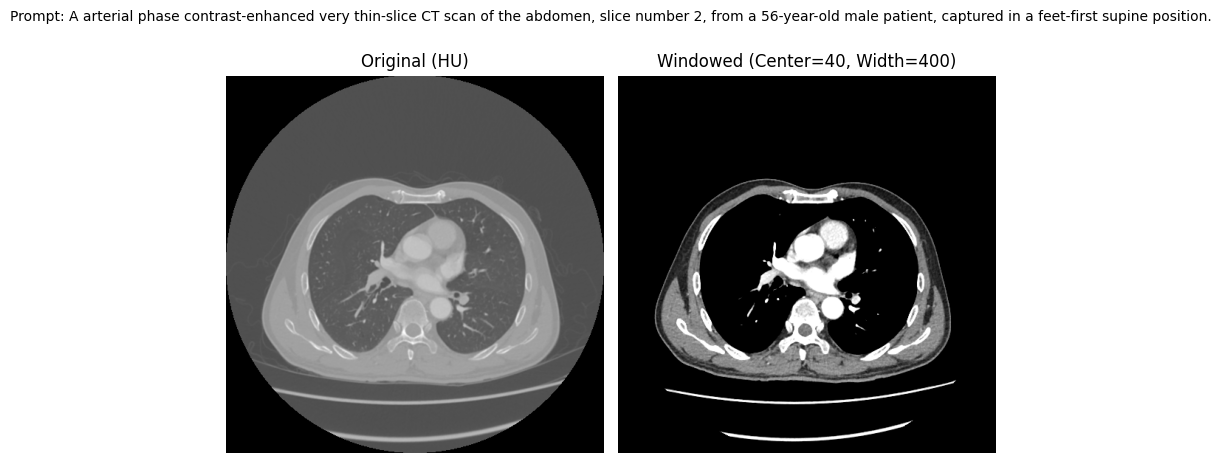

-----------------------------------------------------------------------------------------------------------------------------


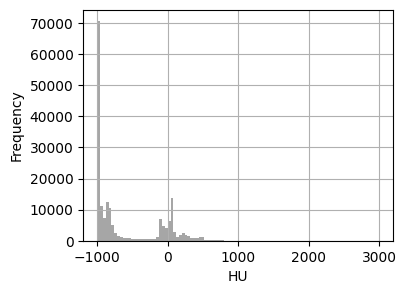

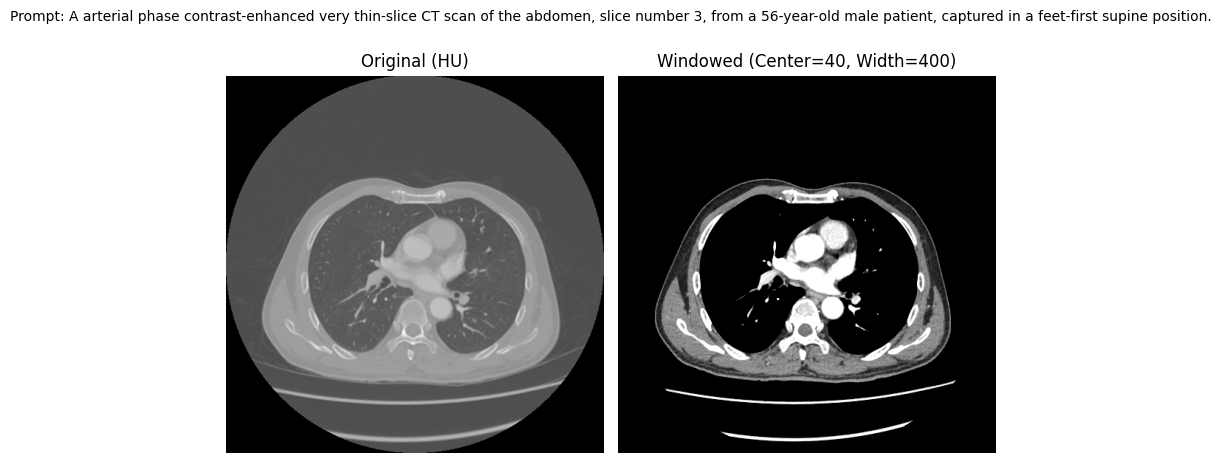

-----------------------------------------------------------------------------------------------------------------------------


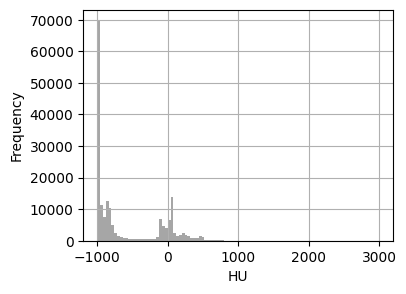

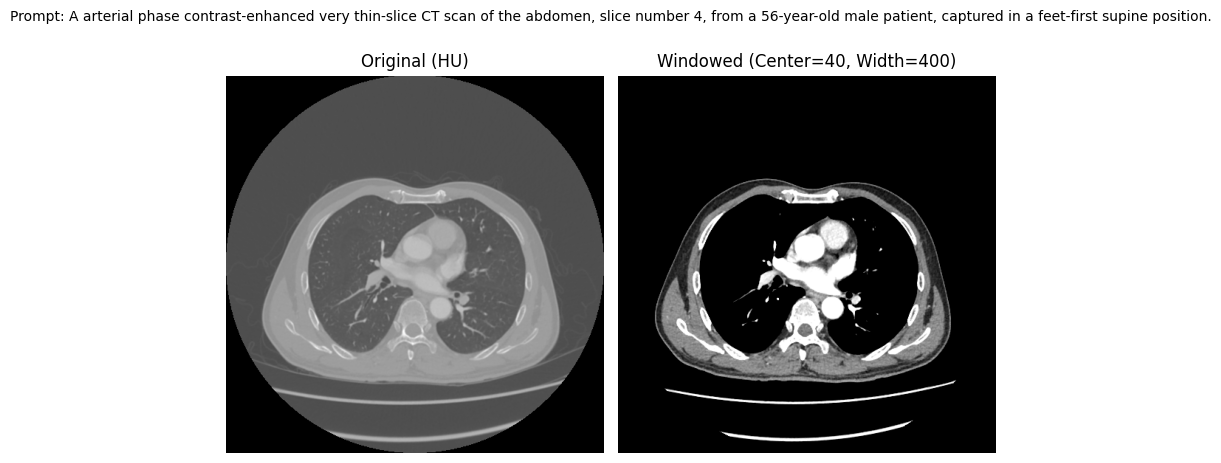

-----------------------------------------------------------------------------------------------------------------------------


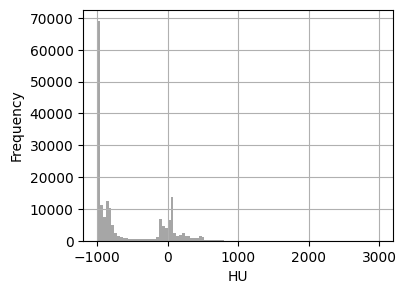

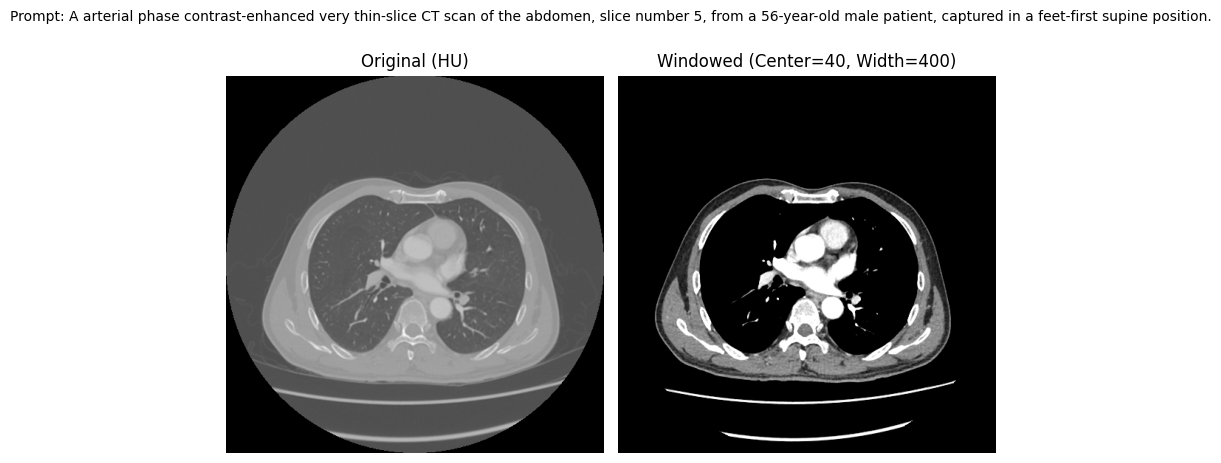

-----------------------------------------------------------------------------------------------------------------------------


In [39]:
plot_images(arterial_df, num_samples=5, window_center=40, window_width=400, range_instance_number=2201, ascending=True)

## Venous phase

In [40]:
venous_df = batch_168588[batch_168588['Label'] == "Venous"]
print(venous_df.shape)
print(f"z_position_range {venous_df['z_position'].max() - venous_df['z_position'].min()}:\n min {venous_df['z_position'].min()} | max {venous_df['z_position'].max()}")
print(f"SliceLocation_range {venous_df['SliceLocation'].max() - venous_df['SliceLocation'].min()}:\n min {venous_df['SliceLocation'].min()} | max {venous_df['SliceLocation'].max()}")
print(f"InstanceNumber: min {venous_df['InstanceNumber'].min()} | max {venous_df['InstanceNumber'].max()}")
print(venous_df['Label'].value_counts())

(1000, 21)
z_position_range 299.70000000000005:
 min 1543.8 | max 1843.5
SliceLocation_range 299.7:
 min -14.5 | max 285.2
InstanceNumber: min 1 | max 1000
Label
Venous          1000
Arterial           0
Non contrast       0
Other              0
Name: count, dtype: int64


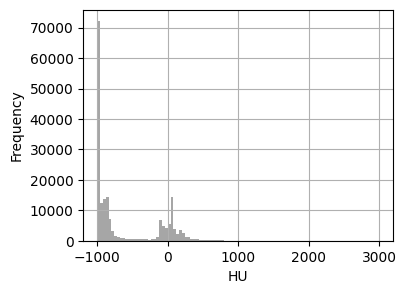

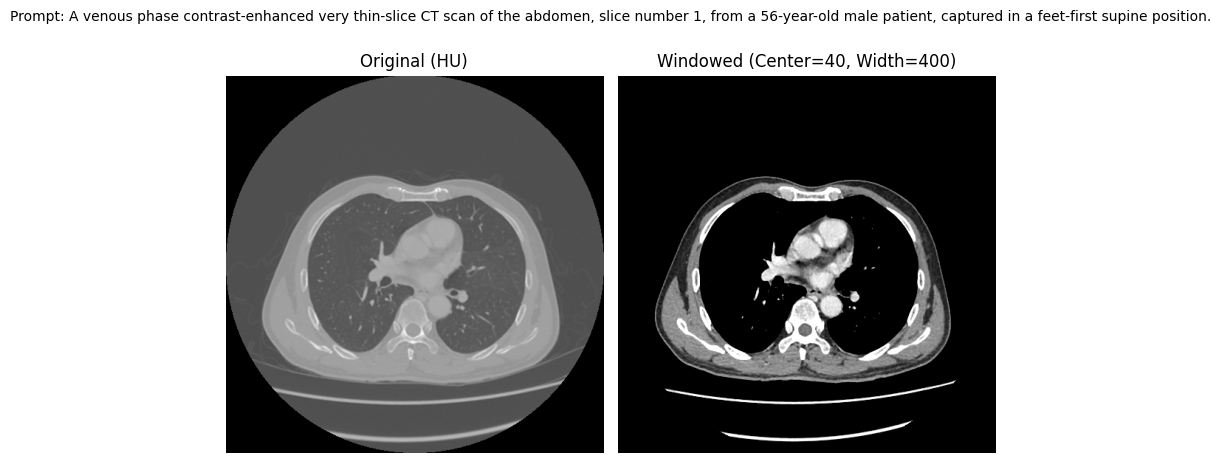

-----------------------------------------------------------------------------------------------------------------------------


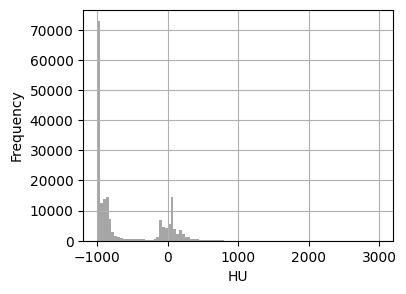

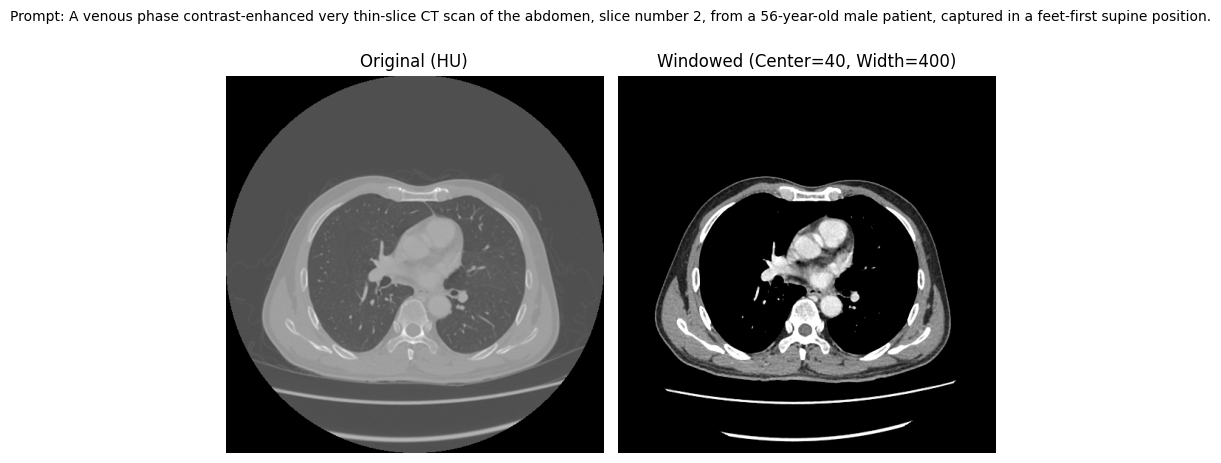

-----------------------------------------------------------------------------------------------------------------------------


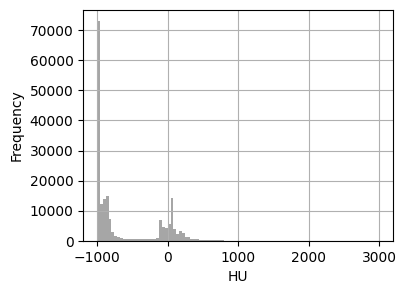

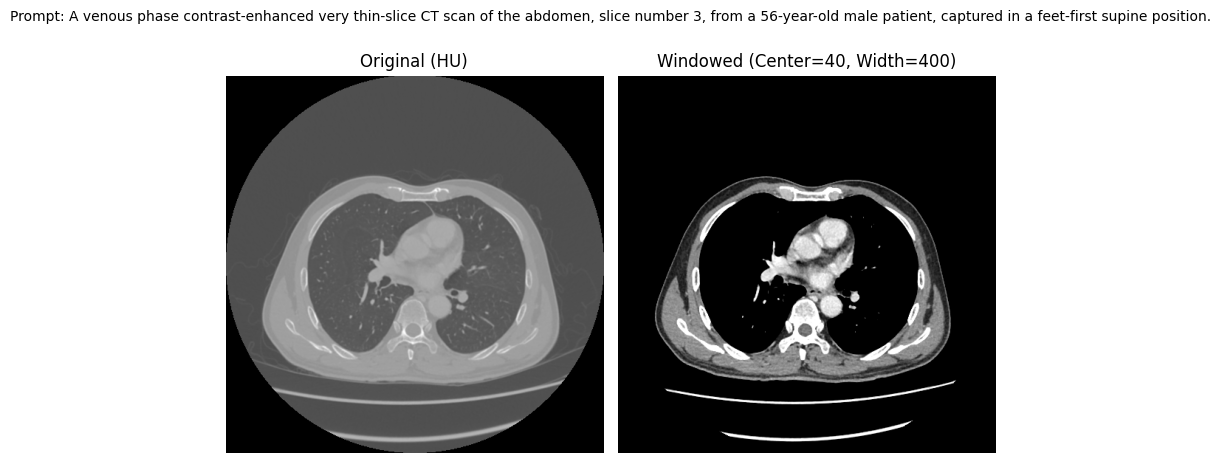

-----------------------------------------------------------------------------------------------------------------------------


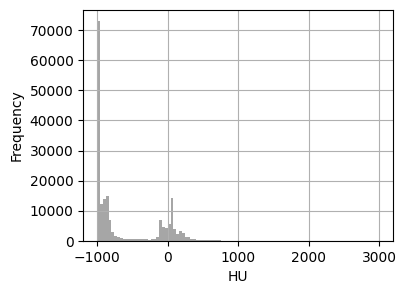

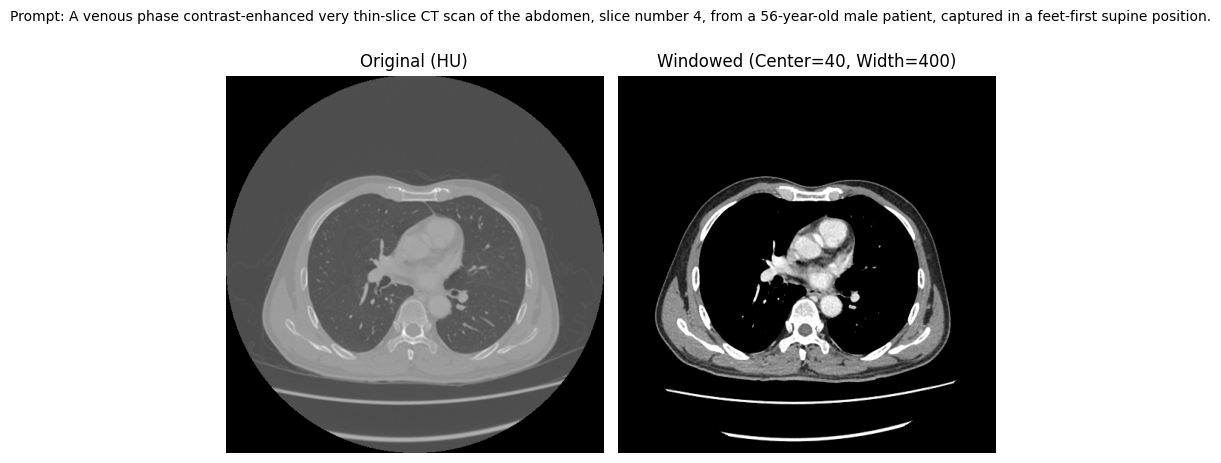

-----------------------------------------------------------------------------------------------------------------------------


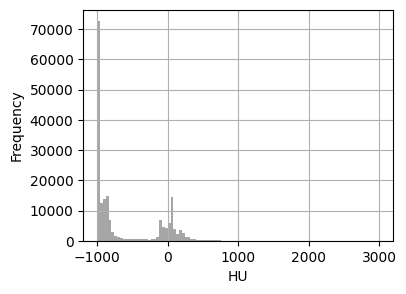

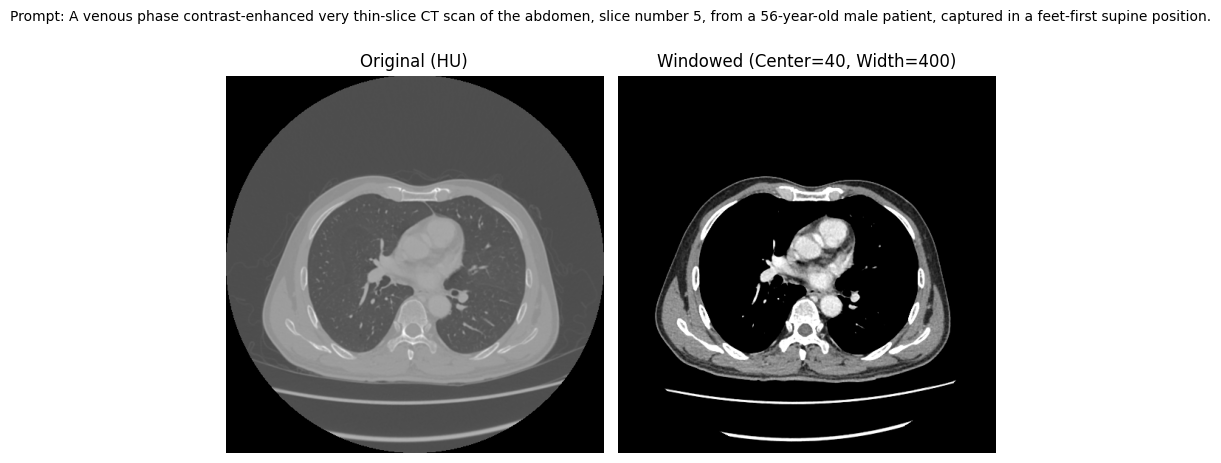

-----------------------------------------------------------------------------------------------------------------------------


In [41]:
plot_images(venous_df, num_samples=5, window_center=40, window_width=400, range_instance_number=2201, ascending=True)

## Folder 1

In [42]:
folder_df = final_df[final_df["InstanceNumber"] % 5 == 0]
print(folder_df.shape)
print(len(folder_df['StudyInstanceUID'].unique()))
print(folder_df['Label'].value_counts())
folder_df.head()

(25105, 21)
54
Label
Venous          8763
Arterial        8449
Non contrast    7893
Other              0
Name: count, dtype: int64


image_path  z_position  \
5   ./data/vindr_multiphase/abdomen_phases/batch1/...      1658.3   
7   ./data/vindr_multiphase/abdomen_phases/batch1/...      1712.3   
12  ./data/vindr_multiphase/abdomen_phases/batch1/...      1677.8   
14  ./data/vindr_multiphase/abdomen_phases/batch1/...      1803.8   
16  ./data/vindr_multiphase/abdomen_phases/batch1/...      1740.8   

                                     StudyInstanceUID  \
5   1.2.392.200036.9116.2.5.1.37.2418751871.143269...   
7   1.2.392.200036.9116.2.5.1.37.2418751871.143269...   
12  1.2.392.200036.9116.2.5.1.37.2418751871.143269...   
14  1.2.392.200036.9116.2.5.1.37.2418751871.143269...   
16  1.2.392.200036.9116.2.5.1.37.2418751871.143269...   

                                    SeriesInstanceUID  \
5   1.2.392.200036.9116.2.5.1.37.2418751871.143269...   
7   1.2.392.200036.9116.2.5.1.37.2418751871.143269...   
12  1.2.392.200036.9116.2.5.1.37.2418751871.143269...   
14  1.2.392.200036.9116.2.5.1.37.2418751871.143269...   
16  1.2.392.200036.9116.2.5.1.37.2418751871.143269...   

                                       SOPInstanceUID PatientSex PatientAge  \
5   1.2.392.200036.9116.2.5.1.37.2418751871.143269...       male         56   
7   1.2.392.200036.9116.2.5.1.37.2418751871.143269...       male         56   
12  1.2.392.200036.9116.2.5.1.37.2418751871.143269...       male         56   
14  1.2.392.200036.9116.2.5.1.37.2418751871.143269...       male         56   
16  1.2.392.200036.9116.2.5.1.37.2418751871.143269...       male         56   

    PatientWeight PatientPosition Modality  ... ScanOptions  \
5            55.0             FFS       CT  ...  HELICAL_CT   
7            55.0             FFS       CT  ...  HELICAL_CT   
12           55.0             FFS       CT  ...  HELICAL_CT   
14           55.0             FFS       CT  ...  HELICAL_CT   
16           55.0             FFS       CT  ...  HELICAL_CT   

   ContrastBolusAgent ContrastBolusStartTime  InstanceNumber  SliceLocation  \
5                 NaN                    NaN             570          170.7   
7                 NaN                    NaN             390          116.7   
12                NaN                    NaN             505          151.2   
14                NaN                    NaN              85           25.2   
16                NaN                    NaN             295           88.2   

      PixelSpacing SliceThickness  \
5   [0.782, 0.782]            0.5   
7   [0.782, 0.782]            0.5   
12  [0.782, 0.782]            0.5   
14  [0.782, 0.782]            0.5   
16  [0.782, 0.782]            0.5   

                              ImageOrientationPatient         Label  \
5   [1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...  Non contrast   
7   [1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...  Non contrast   
12  [1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...  Non contrast   
14  [1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...  Non contrast   
16  [1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...  Non contrast   

                                               prompt  
5   A non contrast phase very thin-slice CT scan o...  
7   A non contrast phase very thin-slice CT scan o...  
12  A non contrast phase very thin-slice CT scan o...  
14  A non contrast phase very thin-slice CT scan o...  
16  A non contrast phase very thin-slice CT scan o...  

[5 rows x 21 columns]

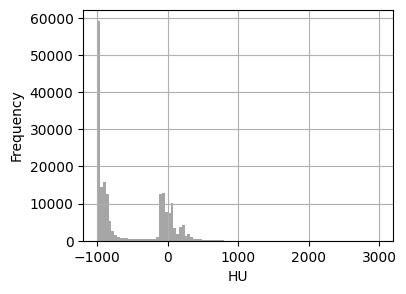

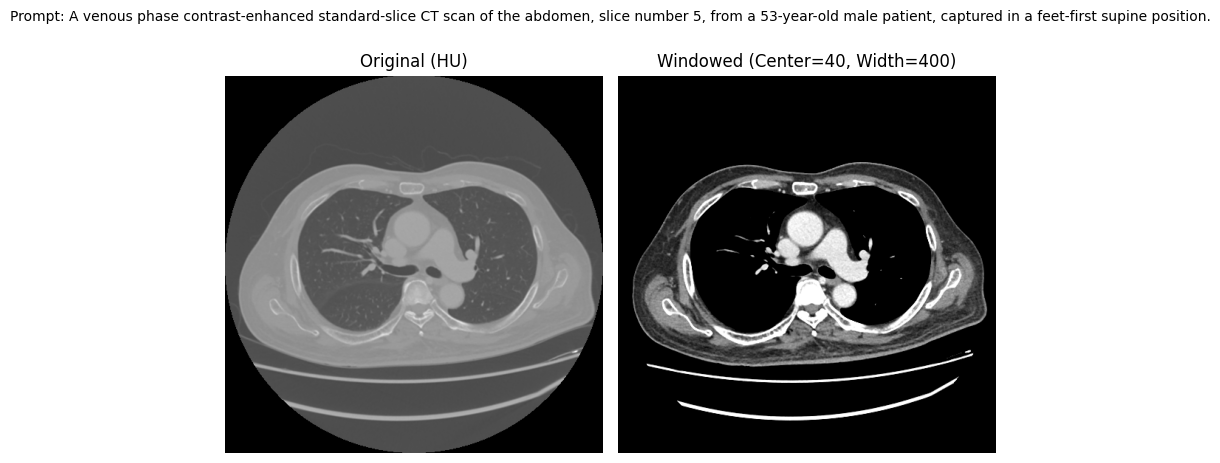

-----------------------------------------------------------------------------------------------------------------------------


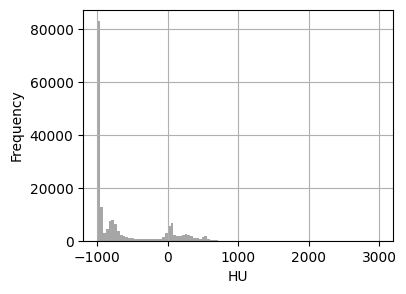

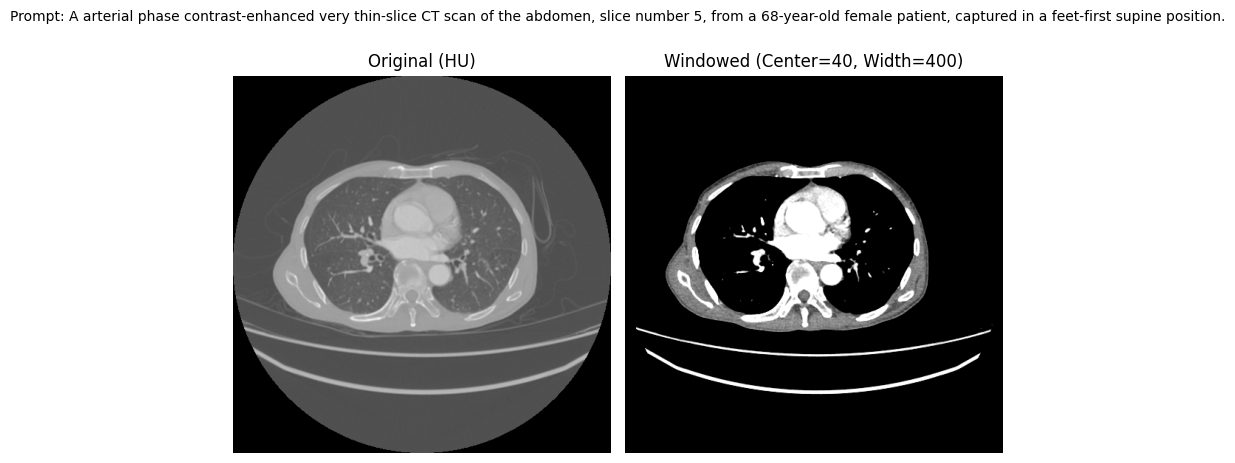

-----------------------------------------------------------------------------------------------------------------------------


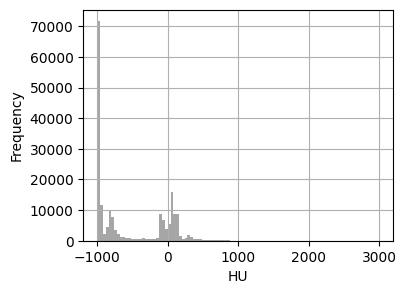

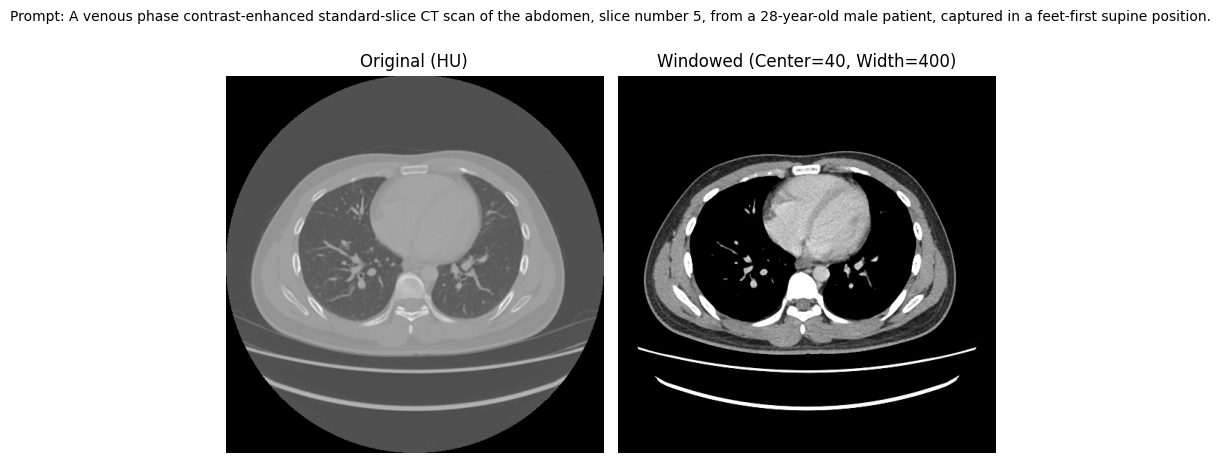

-----------------------------------------------------------------------------------------------------------------------------


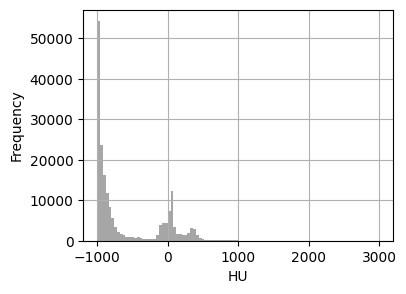

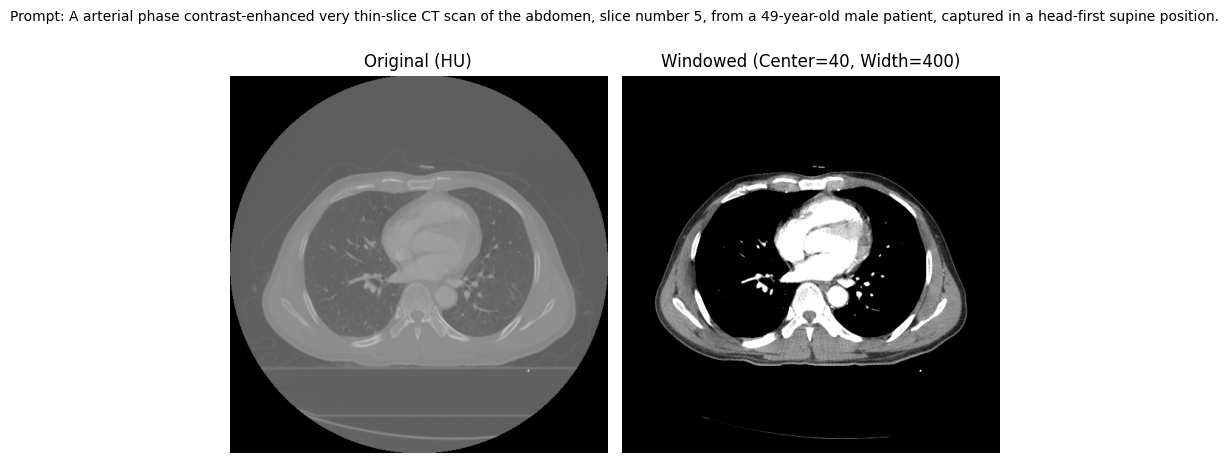

-----------------------------------------------------------------------------------------------------------------------------


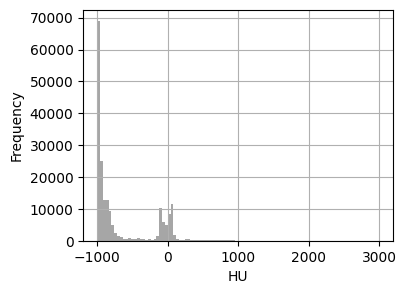

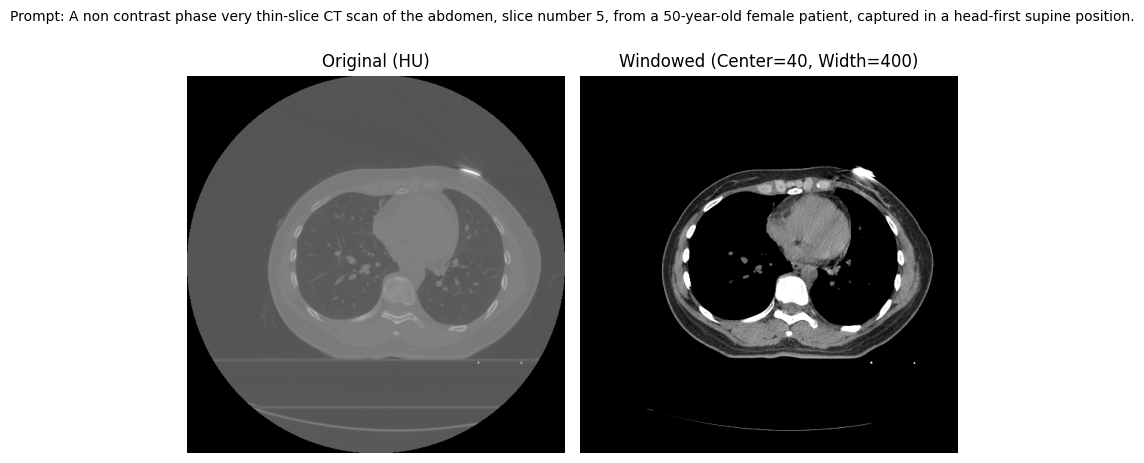

-----------------------------------------------------------------------------------------------------------------------------


In [43]:
plot_images(folder_df, num_samples=5, window_center=40, window_width=400, range_instance_number=2201, ascending=True)

# Save

In [44]:
final_df.to_csv(dataset_dir + "/metadata_prompt.csv", index=False)